[link text](https://)# Synthesis mode classification for Heavy Ion Collisions for diffrent dataset size and K-Folding

**Authors:** [Haydar Mehryar](https://github.com/hmehryar) <br>
**Date created:** 2023/12/01<br>
**Last modified:** 2020/12/20<br>
**Description:** Implementation of Pointnet Deep Network for heavy ion colllisions classifiction

In [1]:
import tensorflow as tf
# device_name = tf.test.gpu_device_name()
# if device_name != '/device:GPU:0':
#   raise SystemError('GPU device not found')
# print('Found GPU at: {}'.format(device_name))
print (tf.__version__)
print(len(tf.config.experimental.list_physical_devices('GPU'))>0)
from tensorflow import keras
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np


2.15.0
False


In [20]:
# from google.colab import drive
# drive.mount('/content/drive')
import sys
sys.path.insert(1,'/wsu/home/gy/gy40/gy4065/hm.jetscapeml.source')
sys.path.insert(1,'/content/drive/My Drive/Projects/110_JetscapeMl/hm.jetscapeml.source')
sys.path.insert(1,'/g/My Drive/Projects/110_JetscapeMl/hm.jetscapeml.source')
sys.path.insert(1,'G:\\My Drive\\Projects\\110_JetscapeMl\\hm.jetscapeml.source')

In [3]:
# loading libraries
print('Loading/Installing Package => Begin\n\n')
import jet_ml_dataset_builder.jet_ml_dataset_builder_utilities as util
from jet_ml_dataset_builder.jet_ml_dataset_builder_utilities import set_directory_paths
from jet_ml_dataset_builder.jet_ml_dataset_builder_utilities import parse_parameters
from jet_ml_dataset_builder.jet_ml_dataset_builder_utilities import load_dataset
from jet_ml_dataset_builder.jet_ml_dataset_builder_utilities import install

import os
from time import time
import glob

import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.callbacks import ModelCheckpoint,History,TensorBoard
from matplotlib import pyplot as plt
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.model_selection import train_test_split, cross_val_score, KFold
from sklearn.preprocessing import OneHotEncoder, StandardScaler
import json
%matplotlib inline

tf.random.set_seed(1234)
print('\nLoading/Installing Package => End\n\n')


Loading/Installing Package => Begin



Loading/Installing Package => End




In [4]:
print('\n########################################################################')
print('Checking the running platforms\n')

# Call the function and retrieve the dataset_directory_path and simulation_directory_path
dataset_directory_path, simulation_directory_path = set_directory_paths()

# Access the dataset_directory_path and simulation_directory_path
print("Dataset Directory Path:", dataset_directory_path)
print("Simulation Directory Path:", simulation_directory_path)
print('########################################################################\n')


########################################################################
Checking the running platforms

Python version: 3.11.5
OS: Windows
OS version: 10
running on Colab: False
Dataset Directory Path: D:\Projects\110_JetscapeMl\hm.jetscapeml.data\
Simulation Results Path: D:\Projects\110_JetscapeMl\hm.jetscapeml.data\simulation_results\
Dataset Directory Path: D:\Projects\110_JetscapeMl\hm.jetscapeml.data\
Simulation Directory Path: D:\Projects\110_JetscapeMl\hm.jetscapeml.data\simulation_results\
########################################################################



In [5]:
tokenized_arguments, tokenized_values = parse_parameters()
# Call the function and retrieve the tokenized parameters
# Access the tokenized arguments and values
print("Tokenized Arguments:")
for argument in tokenized_arguments:
    print(argument)

print("\nTokenized Values:")
for argument, value in tokenized_values.items():
    print(f"{argument}: {value}")

y_class_label_items=['MMAT','MLBT']
alpha_s_items=[0.2 ,0.3 ,0.4]
q0_items=[1.5 ,2.0 ,2.5]

print("y_class_label_items:",y_class_label_items)
print("alpha_s_items:",alpha_s_items)
print("q0_items:",q0_items)

option --f not recognized
Tokenized Arguments:

Tokenized Values:
y_class_label_items: ['MMAT', 'MLBT']
alpha_s_items: [0.2, 0.3, 0.4]
q0_items: [1.5, 2.0, 2.5]


In [6]:
print("Building required params for the loading the dataset file")

class_labels_str = '_'.join(y_class_label_items)
alpha_s_items_str='_'.join(map(str, alpha_s_items))
q0_items_str='_'.join(map(str, q0_items))
# total_size=9*1200000

Building required params for the loading the dataset file


In [7]:
# loading dataset by size and getting just the first column
# Function to load datasets of different sizes
def get_dataset(size):
    dataset_file_name = f"jet_ml_benchmark_config_01_to_09_alpha_{alpha_s_items_str}_q0_{q0_items_str}_{class_labels_str}_size_{size}_shuffled.pkl"

    dataset_file_name=dataset_directory_path+dataset_file_name
    print("dataset_file_name:",dataset_file_name)

    dataset=load_dataset(dataset_file_name,has_test=False)
    (dataset_x, dataset_y) = dataset
    print('Extract the first column for binary classification')
    # dataset_y = dataset_y[:, 0]
    print("dataset.x:",type(dataset_x), dataset_x.size, dataset_x.shape)
    print("dataset.y:",type(dataset_y), dataset_y.size,dataset_y.shape)
    return dataset_x, dataset_y

Building and Compiling the Classifier model

In [10]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.callbacks import ModelCheckpoint, History

def conv_bn(x, filters):
    x = layers.Conv1D(filters, kernel_size=1, padding="valid")(x)
    x = layers.BatchNormalization(momentum=0.0)(x)
    return layers.Activation("relu")(x)


def dense_bn(x, filters):
    x = layers.Dense(filters)(x)
    x = layers.BatchNormalization(momentum=0.0)(x)
    return layers.Activation("relu")(x)


class OrthogonalRegularizer(keras.regularizers.Regularizer):
    def __init__(self, num_features, l2reg=0.001):
        self.num_features = num_features
        self.l2reg = l2reg
        self.eye = tf.eye(num_features)

    def __call__(self, x):
        x = tf.reshape(x, (-1, self.num_features, self.num_features))
        xxt = tf.tensordot(x, x, axes=(2, 2))
        xxt = tf.reshape(xxt, (-1, self.num_features, self.num_features))
        return tf.reduce_sum(self.l2reg * tf.square(xxt - self.eye))

    def get_config(self):
        return {'num_features': self.num_features, 'l2reg': self.l2reg}

def tnet(inputs, num_features):

    # Initalise bias as the indentity matrix
    bias = keras.initializers.Constant(np.eye(num_features).flatten())
    reg = OrthogonalRegularizer(num_features)

    x = conv_bn(inputs, 32)
    x = conv_bn(x, 64)
    x = conv_bn(x, 512)
    x = layers.GlobalMaxPooling1D()(x)
    x = dense_bn(x, 256)
    x = dense_bn(x, 128)
    x = layers.Dense(
        num_features * num_features,
        kernel_initializer="zeros",
        bias_initializer=bias,
        activity_regularizer=reg,
    )(x)
    feat_T = layers.Reshape((num_features, num_features))(x)
    # Apply affine transformation to input features
    return layers.Dot(axes=(2, 1))([inputs, feat_T])

def build_pointnet_classifier_model(NUM_POINTS,NUM_CLASSES, model_name="pointnet"):
    inputs = keras.Input(shape=(NUM_POINTS, 3))
    x = tnet(inputs, 3)
    x = conv_bn(x, 32)
    x = conv_bn(x, 32)
    x = tnet(x, 32)
    x = conv_bn(x, 32)
    x = conv_bn(x, 64)
    x = conv_bn(x, 512)
    x = layers.GlobalMaxPooling1D()(x)
    x = dense_bn(x, 256)
    x = layers.Dropout(0.3)(x)
    x = dense_bn(x, 128)
    x = layers.Dropout(0.3)(x)

    if NUM_CLASSES <=2:
        outputs = layers.Dense(NUM_CLASSES, activation="sigmoid")(x)
    else:
        outputs = layers.Dense(NUM_CLASSES, activation="softmax")(x)
    

    model = keras.Model(inputs=inputs, outputs=outputs, name=model_name)
    return model

In [15]:
# NUM_POINTS = 2048
NUM_POINTS = 1024
# NUM_CLASSES = 10

eloss_pointnet=build_pointnet_classifier_model(NUM_POINTS,NUM_CLASSES=2,model_name="ElossPointNet")
alpha_s_pointnet=build_pointnet_classifier_model(NUM_POINTS,NUM_CLASSES=3,model_name="AlphaSPointNet")
q_0_pointnet=build_pointnet_classifier_model(NUM_POINTS,NUM_CLASSES=4,model_name="Q0PointNet")
learning_rate=0.001

In [16]:
def compile_pointnet_classifier_model_with_hyperparam(model,learning_rate,num_classes):
  if num_classes==None:
    raise Exception("Number of classses are not defined!")
  optimizer = keras.optimizers.Adam(learning_rate=learning_rate)
  
  loss="binary_crossentropy"
  metrics=["accuracy"]
  
  if num_classes>2:
    loss="sparse_categorical_crossentropy"
    metrics=["sparse_categorical_accuracy"]
  model.compile(
      loss=loss,
      optimizer=optimizer,
      metrics=metrics,
  )
  model.summary()
  return model

In [17]:
eloss_pointnet=compile_pointnet_classifier_model_with_hyperparam(eloss_pointnet,learning_rate,num_classes=2)
alpha_s_pointnet=compile_pointnet_classifier_model_with_hyperparam(alpha_s_pointnet,learning_rate,num_classes=3)
q_0_pointnet=compile_pointnet_classifier_model_with_hyperparam(q_0_pointnet,learning_rate,num_classes=4)


Model: "ElossPointNet"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_4 (InputLayer)        [(None, 1024, 3)]            0         []                            
                                                                                                  
 conv1d_33 (Conv1D)          (None, 1024, 32)             128       ['input_4[0][0]']             
                                                                                                  
 batch_normalization_51 (Ba  (None, 1024, 32)             128       ['conv1d_33[0][0]']           
 tchNormalization)                                                                                
                                                                                                  
 activation_51 (Activation)  (None, 1024, 32)             0         ['batch_normalizat

                                                                                                  
 activation_54 (Activation)  (None, 256)                  0         ['batch_normalization_54[0][0]
                                                                    ']                            
                                                                                                  
 dense_28 (Dense)            (None, 128)                  32896     ['activation_54[0][0]']       
                                                                                                  
 batch_normalization_55 (Ba  (None, 128)                  512       ['dense_28[0][0]']            
 tchNormalization)                                                                                
                                                                                                  
 activation_55 (Activation)  (None, 128)                  0         ['batch_normalization_55[0][0]
          

In [18]:
tf.keras.utils.plot_model(eloss_pointnet, show_shapes=True)
tf.keras.utils.plot_model(alpha_s_pointnet, show_shapes=True)
tf.keras.utils.plot_model(q_0_pointnet, show_shapes=True)

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model to work.
You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model to work.
You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model to work.


In [13]:
def split_dataset(dataset_x, dataset_y, test_size=0.2, random_state=None):
    """
    Split the dataset into training and testing sets.

    Parameters:
    - dataset_x: The input data (3D array).
    - dataset_y: The target values (2D array).
    - test_size: The proportion of the dataset to include in the test split.
    - random_state: Seed for random number generation.

    Returns:
    - x_train, x_test: The split input data for training and testing.
    - y_train, y_test: The split target values for training and testing.
    """
    # Flatten the input data to 2D
    flattened_dataset_x = dataset_x.reshape(dataset_x.shape[0], -1)

    # Split the dataset
    x_train, x_test,  y_train, y_test = \
        train_test_split(flattened_dataset_x, dataset_y, test_size=test_size, random_state=random_state)

    # Reshape the input data back to 3D
    x_train = x_train.reshape(x_train.shape[0], dataset_x.shape[1], dataset_x.shape[2])
    x_test = x_test.reshape(x_test.shape[0], dataset_x.shape[1], dataset_x.shape[2])

    return x_train, x_test, y_train, y_test

In [14]:
def parse_dataset(x_train,x_test):
    train_labels = []
    test_labels = []
    i=0
    for f in x_train:

        train_labels.append(i)
        i=i+1
    for f in x_test:
        test_labels.append(i)
        i=i+1
    return (
        np.array(train_labels),
        np.array(test_labels),
    )

In [15]:
def augment(points, label):
    # jitter points
    points += tf.random.uniform(points.shape, -0.005, 0.005, dtype=tf.float64)
    # shuffle points
    points = tf.random.shuffle(points)
    return points, label

In [16]:
def evaluate_model(model, x_test, y_test, is_binary_classification=False):
    """
    Evaluate the performance of a trained model on test data.

    Parameters:
    - model: The trained deep neural model.
    - x_test: Test data, it shall be in the flatten format, each entry contains 1024x1 data.
    - y_test: True labels.

    Returns:
    - accuracy: Accuracy of the model on the test data.
    - confusion_matrix: Confusion matrix for the predictions.
    """
    # Assuming model is your trained deep neural model
    y_pred = model.predict(x_test)
    print("y_pred",y_pred)
    y_pred_class = np.argmax(y_pred, axis=1)  # Extracting the class with the highest probability

    if is_binary_classification:
        # Assuming y_true is a Nx2 array where each row contains the true class probabilities
        y_true_class = np.argmax(y_test, axis=1)  # Extracting the class with the highest true probability
        accuracy = accuracy_score(y_true_class, y_pred_class)
        cm = confusion_matrix(y_true_class, y_pred_class)
    else:
        accuracy=accuracy_score(y_test,y_pred_class)
        cm = confusion_matrix(y_test, y_pred_class)
    
    print(f'Accuracy: {accuracy}')
    print(f'Confusion Matrix: {cm}')

    return accuracy, cm

# Example usage:
# accuracy, confusion_matrix = evaluate_model(trained_model, test_data, true_labels)


In [17]:
def preprocess_y_eloss(y_train,y_test):
    # One-hot encode the categorical variable for eloss
    # print(y_train)
    y_train_0_categorical = np.array(y_train).reshape(-1, 1)
    y_test_0_categorical = np.array(y_test).reshape(-1, 1)

    encoder = OneHotEncoder(sparse_output=False)
    y_train_0_categorical_encoded = encoder.fit_transform(y_train_0_categorical)
    y_test_0_categorical_encoded = encoder.transform(y_test_0_categorical)
    return y_train_0_categorical_encoded,y_test_0_categorical_encoded

def convert_y_to_float(y_train,y_test):
    y_train = y_train.astype(np.float32)
    y_test= y_test.astype(np.float32)
    return y_train,y_test

from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelEncoder
def convert_y_to_integer_categorical(y_train,y_test):
    # Step 1: Convert string labels to integer labels
    label_encoder = LabelEncoder()
    y_train_encoded = label_encoder.fit_transform(y_train)
    y_test_encoded= label_encoder.fit_transform(y_test)
    num_classes = len(label_encoder.classes_)
    return y_train_encoded,y_test_encoded, num_classes

def convert_y_to_categorical(y_train,y_test):
    # # Step 1: Convert string labels to integer labels
    # label_encoder = LabelEncoder()
    # y_train_encoded = label_encoder.fit_transform(y_train)
    # y_test_encoded= label_encoder.fit_transform(y_test)
    y_train_encoded,y_test_encoded,num_classes=convert_y_to_integer_categorical(y_train,y_test)
    # Step 2: Convert integer labels to one-hot encoded format
    # num_classes = len(label_encoder.classes_)
    y_train_categorical = to_categorical(y_train_encoded, num_classes=num_classes)
    y_test_categorical = to_categorical(y_test_encoded, num_classes=num_classes)

    return y_train_categorical,y_test_categorical



def preprocess_y_alpha_s(y_train,y_test):
    y_train_categorical,y_test_categorical,num_classes =convert_y_to_integer_categorical(y_train,y_test)
    return y_train_categorical,y_test_categorical

def preprocess_y_q_0(y_train,y_test):
    y_train_categorical,y_test_categorical,num_classes =convert_y_to_integer_categorical(y_train,y_test)
    return y_train_categorical,y_test_categorical

In [18]:
def preprocess_dataset(dataset_x, dataset_y):
  print("Pre-processing")
  # Example usage:
  x_train, x_test, y_train, y_test= \
    split_dataset(dataset_x, dataset_y, test_size=0.2, random_state=None)
  print("deleting the original dataset after splitting ...")
  del dataset_x,dataset_y
  
  print("x_train:",type(x_train), x_train.size, x_train.shape)
  print("y_train:",type(y_train), y_train.size,y_train.shape)

  print("x_test:",type(x_test), x_test.size, x_test.shape)
  print("y_test:",type(y_test), y_test.size,y_test.shape)
  
  # train_labels, test_labels = parse_dataset(x_train,x_test)
  # print(train_labels.size,test_labels.size)

  # BATCH_SIZE = 32

  # train_dataset = train_dataset.shuffle(len(x_train)).map(augment).batch(BATCH_SIZE)
  # test_dataset = test_dataset.shuffle(len(x_test)).batch(BATCH_SIZE)

  print("Preprocess y_train and y_test")
  y_train_eloss, y_test_eloss,y_train_alpha_s, y_test_alpha_s,y_train_q_0, y_test_q_0=([],[],[],[],[],[])

  
  print("y_train[:,0]:",type(y_train[:,0]), y_train[:,0].size,y_train[:,0].shape)
  y_train_eloss, y_test_eloss=preprocess_y_eloss(y_train[:,0],y_test[:,0])
  print(y_train[:4,0])
  print(y_train_eloss[:4])

  print("y_train[:,1]:",type(y_train[:,1]), y_train[:,1].size,y_train[:,1].shape)
  y_train_alpha_s, y_test_alpha_s=preprocess_y_alpha_s(y_train[:,1],y_test[:,1])
  print(y_train[:4,1])
  print(y_train_alpha_s[:4])

  print("y_train[:,2]:",type(y_train[:,2]), y_train[:,2].size,y_train[:,2].shape)
  y_train_q_0, y_test_q_0=preprocess_y_q_0(y_train[:,2],y_test[:,2])
  print(y_train[:4,1])
  print(y_train_alpha_s[:4])

  return (x_train, y_train_eloss,y_train_alpha_s,y_train_q_0, \
          x_test, y_test_eloss,y_test_alpha_s,y_test_q_0)
# (dataset_x, dataset_y)= get_dataset(1000)
# (x_train, y_train_eloss,y_train_alpha_s,y_train_q_0, \
#   x_test, y_test_eloss,y_test_alpha_s,y_test_q_0)=\
# preprocess_dataset(dataset_x, dataset_y)

In [19]:
def plot_training_history(history,simulation_path):
    # Plot training & validation accuracy values
    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('Model Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend(['Train', 'Validation'], loc='upper left')
    # Set ticks on the epoch axis to display only integer values
    plt.xticks(range(0, len(history.history['accuracy'])+1,5))

    # Plot training & validation loss values
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Model Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend(['Train', 'Validation'], loc='upper left')

    # Set ticks on the epoch axis to display only integer values
    plt.xticks(range(0, len(history.history['accuracy'])+1,5))

    # Adjust layout and show the plot
    plt.tight_layout()


    # Save the plot with high resolution (300 dpi)
    file_name='_accuracy_loss.png'
    file_path=simulation_path+file_name
    plt.savefig(file_path, dpi=300)
    plt.show()
    plt.close()
    return file_path

# Plot the training history
# plot_training_history_path=plot_training_history(history,simulation_path)

In [20]:
def save_training_history(history,simulation_path):
  # Save the training history to a file (e.g., JSON format)

  training_history_file_path =simulation_path+'_training_history'
  # training_history_file_path  =simulation_directory_path+training_history_file_name

  training_history_file_path_json=training_history_file_path+'.json'
  with open(training_history_file_path_json, 'w') as f:
      json.dump(history.history, f)
  print(training_history_file_path_json)

  training_history_file_path_csv=training_history_file_path+'.csv'
  pd.DataFrame.from_dict(history.history).to_csv(training_history_file_path_csv,index=False)
  print(training_history_file_path_csv)

  training_history_file_path_npy=training_history_file_path+'.npy'
  np.save(training_history_file_path_npy,history.history)
  print(training_history_file_path_npy)
  return training_history_file_path_json,training_history_file_path_csv,training_history_file_path_csv

# training_history_file_path_json,training_history_file_path_csv,training_history_file_path_csv = \
#   save_training_history(history,simulation_path)

In [21]:
# train and evaluate classifiers
# This method shall get the cloud points as the trainset, to be trained by pointnet

from tensorflow.keras.callbacks import ModelCheckpoint, History, TensorBoard

def train_and_evaluate_classifier_kfold(model, x_train,y_train , x_test, y_test, n_epochs, monitor, k_folds,simulation_path,is_binary_classification):

    # Use KFold for k-fold cross-validation
    kfold = KFold(n_splits=k_folds, shuffle=True, random_state=42)

    accuracies = []
    cms = []
    train_times = []
    all_histories = []  # Store histories for each fold
    plots=[]
    models=[]
    for fold, (train_index, val_index) in enumerate(kfold.split(x_train)):
    # train_index, val_index in kfold.split(x_train):
        x_train_fold, x_val_fold = x_train[train_index], x_train[val_index]
        y_train_fold, y_val_fold = y_train[train_index], y_train[val_index]

        # Include both ModelCheckpoint and History callbacks in the callbacks list
        # callbacks=[checkpoint_callback]
        fold_path=f'{simulation_path}_fold_{fold}'
        # Use ModelCheckpoint callback to save the best model
        best_model_file_path = f'{fold_path}_best_model.keras'

        models.append(best_model_file_path)
        checkpoint_callback = ModelCheckpoint(
            best_model_file_path,
            monitor=monitor,
            save_best_only=True,
            mode="max" if monitor == "val_accuracy" else "min",
            verbose=1
        )

        # Use History callback to retrieve the training history
        history_callback = History()
        log_dir=f'{simulation_path}/'
        tensorboard_callback = TensorBoard(log_dir=log_dir, histogram_freq=1)

        start = time()
        history = model.fit(
            x_train_fold,
            y_train_fold,
            epochs=n_epochs,
            validation_data=(x_val_fold, y_val_fold),
            callbacks=[checkpoint_callback,history_callback
                       ,tensorboard_callback
                       ]
        )
        train_time = (time()-start)/60.0
        train_times.append(train_time)
        # Append history to the list
        all_histories.append(history.history)

        plot=plot_training_history(history,fold_path)
        training_history_file_path_json,training_history_file_path_csv,training_history_file_path_csv = \
         save_training_history(history,fold_path)
        plots.append(plot)

        accuracy, confusion_matrix = evaluate_model(model, x_test, y_test,is_binary_classification)
        accuracies.append(accuracy)
        cms.append(confusion_matrix)

    return accuracies, cms, train_times, all_histories, plots,models

In [33]:
# Load the DataFrame from the saved file
# def load_csv_into_dataframe(file_path):
#   df_results = pd.read_csv(file_path, sep='\t')
#   return df_results
# #example usage
# results_kfold_errorbar_path=simulation_path+'_results_kfold_errorbar-all-dataset.txt'
# results_kfold_errorbar_path
# # df_results=load_csv_into_dataframe("/content/drive/MyDrive/Colab Notebooks/binary_classification_results_kfold_errorbar.txt")
# df_results=load_csv_into_dataframe(results_kfold_errorbar_path)
# df_results

,Dataset_Size,Classifier,Mean_Accuracy,Std_Accuracy
0,1000,ElossNet,0.578000,0.004000
1,1000,ElossNet,0.578000,0.004000
2,1000,ElossNet,0.578000,0.004000
3,1000,ElossNet,0.578000,0.004000
4,1000,ElossNet,0.578000,0.004000
...,...,...,...,...
115,1000000,Q0Net,0.617495,0.002716
116,1000000,Q0Net,0.617495,0.002716
117,1000000,Q0Net,0.617495,0.002716
118,1000000,Q0Net,0.617495,0.002716


     Dataset_Size Classifier  Mean_Accuracy  Std_Accuracy
0            1000   ElossNet       0.578000      0.004000
1            1000   ElossNet       0.578000      0.004000
2            1000   ElossNet       0.578000      0.004000
3            1000   ElossNet       0.578000      0.004000
4            1000   ElossNet       0.578000      0.004000
..            ...        ...            ...           ...
115       1000000      Q0Net       0.617495      0.002716
116       1000000      Q0Net       0.617495      0.002716
117       1000000      Q0Net       0.617495      0.002716
118       1000000      Q0Net       0.617495      0.002716
119       1000000      Q0Net       0.617495      0.002716

[120 rows x 4 columns]


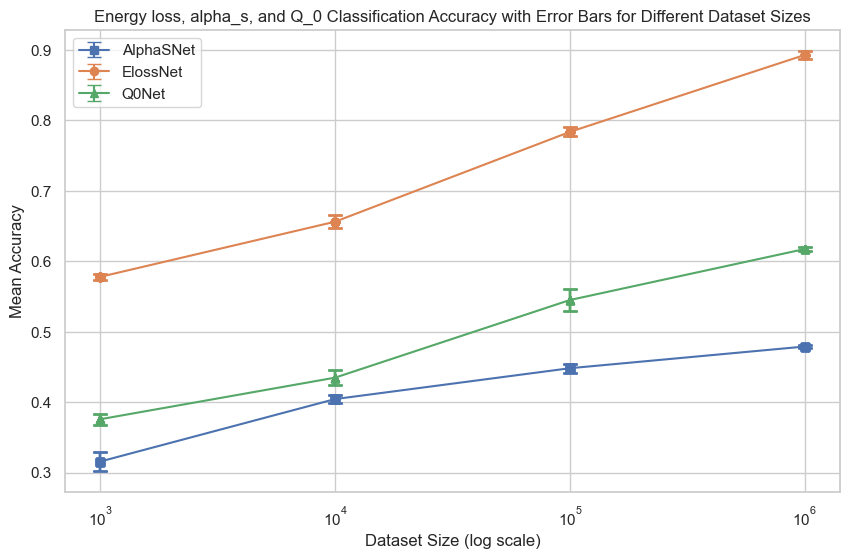

In [34]:
# plot_save_mean_error_bar(df_results,simulation_path)

In [23]:
def plot_save_mean_error_bar(df_results,simulation_path):
    # df_results= df_results_kfold_errorbar
    print(df_results)
    # Set a seaborn style (optional)
    sns.set(style="whitegrid")
    


    # Define a dictionary to map classifiers to markers
    marker_dict = {

        'ElossNet': 'o',
        'AlphaSNet': 's',
        'Q0Net': '^'
    }
    plt.figure(figsize=(10, 6))

    for clf_name, group in df_results.groupby('Classifier'):
        plt.errorbar(
            group['Dataset_Size'],
            group['Mean_Accuracy'],
            yerr=group['Std_Accuracy'],
            label=clf_name,
            marker=marker_dict.get(clf_name, 'o'),  # Use 'o' as default marker if not found in the dictionary
            capsize=5
        )

    plt.xscale('log')  # Set x-axis to logarithmic scale
    plt.xlabel('Dataset Size (log scale)')
    plt.ylabel('Mean Accuracy')
    plt.title('Energy loss, alpha_s, and Q_0 Classification Accuracy with Error Bars for Different Dataset Sizes')
    plt.legend()
    # plt.grid(True)
    # Save the plot with high resolution (300 dpi)
    accuracy_errorbar_plot_path=simulation_path+'_results_accuracy_errorbar_plot.png'
    plt.savefig(accuracy_errorbar_plot_path, dpi=300)
    plt.show()

In [24]:
def train_and_evaluate_classifier_for_all_datasets(dataset_sizes,classifiers,simulation_path,n_epochs, monitor, k_folds):
  print(simulation_path)
  # Results storage
  results_kfold = []
  results_kfold_errorbar=[]
  # Loop through different dataset sizes
  for size in dataset_sizes:
      current_simulation_name=f'_size_{size}'
      current_simulation_path=simulation_path+current_simulation_name
      print(current_simulation_path)
      # Generate dataset
      # x, y = get_dataset(size)
      (dataset_x, dataset_y)= get_dataset(size)
      (x_train, y_train_eloss,y_train_alpha_s,y_train_q_0, \
       x_test, y_test_eloss,y_test_alpha_s,y_test_q_0)=\
        preprocess_dataset(dataset_x, dataset_y)

      # Loop through classifiers
      for clf_name, clf in classifiers.items():
        current_classifier_name=f'_classifier_{clf_name}'
        current_simulation_path_with_classifier=current_simulation_path+current_classifier_name
        print(current_simulation_path_with_classifier)
        is_binary_classification=False
        # Choose the appropriate y_train and y_test based on clf_name
        if clf_name == 'ElossNet':
            y_train, y_test = y_train_eloss, y_test_eloss
            is_binary_classification=True
        elif clf_name == 'AlphaSNet':
            y_train, y_test = y_train_alpha_s, y_test_alpha_s
        elif clf_name == 'Q0Net':
            y_train, y_test = y_train_q_0, y_test_q_0
        else:
            raise ValueError(f"Unknown classifier name: {clf_name}")
        # print("y_trian",y_train[:10])
        # print("y_test",y_test[:10])
        # Evaluate classifier using k-fold cross-validation
        fold_accuracies, fold_conf_matrices, fold_train_times, all_histories, plots, models = \
        train_and_evaluate_classifier_kfold(clf, x_train,  y_train,x_test,  y_test, n_epochs, monitor, k_folds,current_simulation_path_with_classifier,is_binary_classification )

        # Store results for each fold
        for fold_num, (accuracy, cm,train_time,plot,model) in enumerate(zip(fold_accuracies, fold_conf_matrices,fold_train_times,plots,models), start=1):
            results_kfold.append({
                'Dataset Size': size,
                'Classifier': clf_name,
                'Fold Number': fold_num,
                'Accuracy': accuracy,
                'Confusion Matrix': cm,
                'Train Time': train_time,
                'Loss/Accuracy Plot Path': plot,
                'Best Model Path': model
            })
            print(f'Average Train Time: {np.mean(fold_train_times)} minutes')
            # Calculate mean and standard deviation of accuracy scores
            mean_accuracy = np.mean(fold_accuracies)
            std_accuracy = np.std(fold_accuracies)

            # Store results
            results_kfold_errorbar.append({
                'Dataset_Size': size,
                'Classifier': clf_name,
                'Mean_Accuracy': mean_accuracy,
                'Std_Accuracy': std_accuracy
            })
  # Create a DataFrame from k-fold results
  df_results_kfold = pd.DataFrame(results_kfold)
  # Save the DataFrame to a text file
  results_kfold_path=simulation_path+'_results_kfold.txt'
  df_results_kfold.to_csv(results_kfold_path, index=False, sep='\t')
  # Display results in a table
  print(df_results_kfold)

  # Create a DataFrame from k-fold results
  df_results_kfold_errorbar = pd.DataFrame(results_kfold_errorbar)
  # Save the DataFrame to a text file
  results_kfold_errorbar_path=simulation_path+'_results_kfold_errorbar.txt'
  df_results_kfold_errorbar.to_csv(results_kfold_errorbar_path, index=False, sep='\t')
  # Display results in a table
  print(df_results_kfold_errorbar)
  plot_save_mean_error_bar(df_results_kfold_errorbar,simulation_path)

In [25]:
# Classifiers 'ElossNet','AlphaSNet','Q0Net'
classifiers = {
    'ElossNet': eloss_net,
    'AlphaSNet':alpha_s_net,
    'Q0Net':q_0_net
}

D:\Projects\110_JetscapeMl\hm.jetscapeml.data\simulation_results\
D:\Projects\110_JetscapeMl\hm.jetscapeml.data\simulation_results\jetml_classification
D:\Projects\110_JetscapeMl\hm.jetscapeml.data\simulation_results\jetml_classification_size_1000000
dataset_file_name: D:\Projects\110_JetscapeMl\hm.jetscapeml.data\jet_ml_benchmark_config_01_to_09_alpha_0.2_0.3_0.4_q0_1.5_2.0_2.5_MMAT_MLBT_size_1000000_shuffled.pkl
dataset.x: <class 'numpy.ndarray'> 1024000000 (1000000, 32, 32)
dataset.y: <class 'numpy.ndarray'> 3000000 (1000000, 3)
Extract the first column for binary classification
dataset.x: <class 'numpy.ndarray'> 1024000000 (1000000, 32, 32)
dataset.y: <class 'numpy.ndarray'> 3000000 (1000000, 3)
Pre-processing
deleting the original dataset after splitting ...
x_train: <class 'numpy.ndarray'> 819200000 (800000, 32, 32)
y_train: <class 'numpy.ndarray'> 2400000 (800000, 3)
x_test: <class 'numpy.ndarray'> 204800000 (200000, 32, 32)
y_test: <class 'numpy.ndarray'> 600000 (200000, 3)
Pre

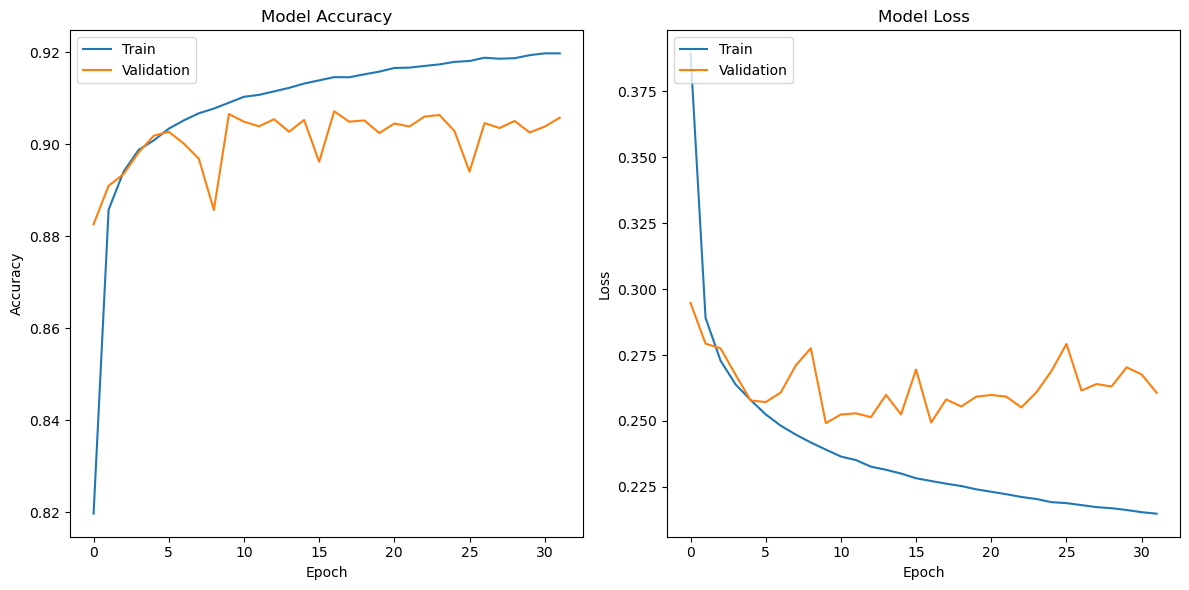

D:\Projects\110_JetscapeMl\hm.jetscapeml.data\simulation_results\jetml_classification_size_1000000_classifier_ElossNet_fold_0_training_history.json
D:\Projects\110_JetscapeMl\hm.jetscapeml.data\simulation_results\jetml_classification_size_1000000_classifier_ElossNet_fold_0_training_history.csv
D:\Projects\110_JetscapeMl\hm.jetscapeml.data\simulation_results\jetml_classification_size_1000000_classifier_ElossNet_fold_0_training_history.npy
6250/6250 [==============================] - 9s 1ms/step
y_pred [[1.1696229e-02 9.8830378e-01]
 [9.2576706e-01 7.4232951e-02]
 [9.9999845e-01 1.5788770e-06]
 ...
 [2.0293787e-03 9.9797064e-01]
 [1.0381791e-01 8.9618212e-01]
 [9.9940735e-01 5.9264869e-04]]
Accuracy: 0.90516
Confusion Matrix: [[88354 11675]
 [ 7293 92678]]
Epoch 1/32
22487/22500 [============================>.] - ETA: 0s - loss: 0.2200 - accuracy: 0.9181
Epoch 1: val_accuracy improved from -inf to 0.91714, saving model to D:\Projects\110_JetscapeMl\hm.jetscapeml.data\simulation_results\j

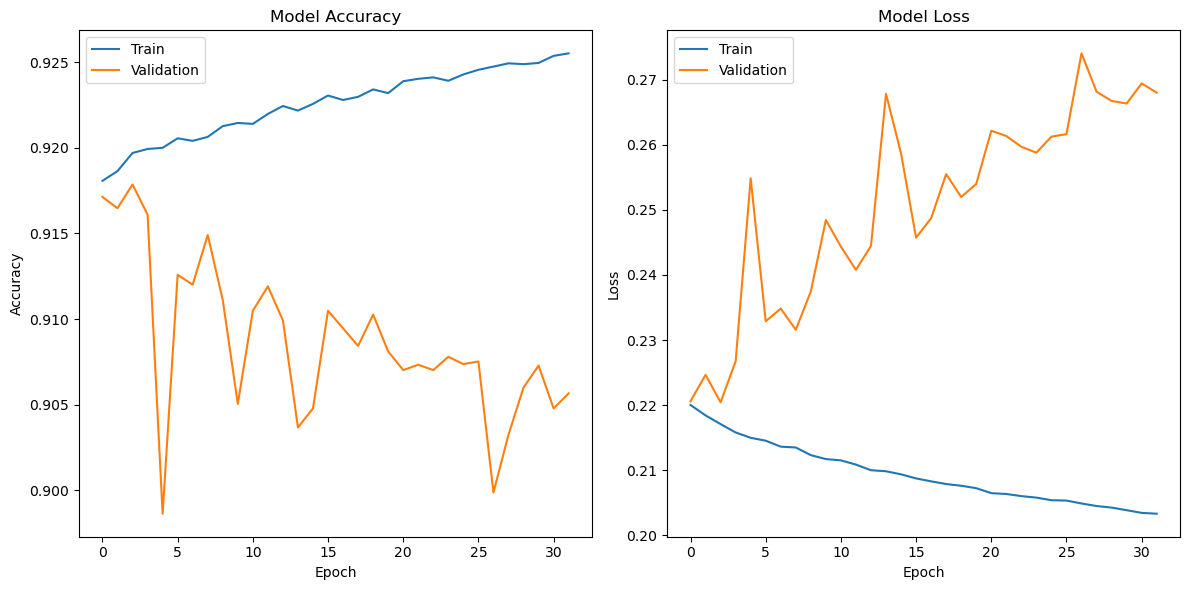

D:\Projects\110_JetscapeMl\hm.jetscapeml.data\simulation_results\jetml_classification_size_1000000_classifier_ElossNet_fold_1_training_history.json
D:\Projects\110_JetscapeMl\hm.jetscapeml.data\simulation_results\jetml_classification_size_1000000_classifier_ElossNet_fold_1_training_history.csv
D:\Projects\110_JetscapeMl\hm.jetscapeml.data\simulation_results\jetml_classification_size_1000000_classifier_ElossNet_fold_1_training_history.npy
6250/6250 [==============================] - 6s 1ms/step
y_pred [[1.2424710e-02 9.8757529e-01]
 [9.7922695e-01 2.0773049e-02]
 [9.9999988e-01 1.1737481e-07]
 ...
 [3.1121150e-03 9.9688786e-01]
 [1.3204855e-01 8.6795145e-01]
 [9.9987006e-01 1.2996441e-04]]
Accuracy: 0.90167
Confusion Matrix: [[89857 10172]
 [ 9494 90477]]
Epoch 1/32
22482/22500 [============================>.] - ETA: 0s - loss: 0.2110 - accuracy: 0.9228
Epoch 1: val_accuracy improved from -inf to 0.92051, saving model to D:\Projects\110_JetscapeMl\hm.jetscapeml.data\simulation_results\j

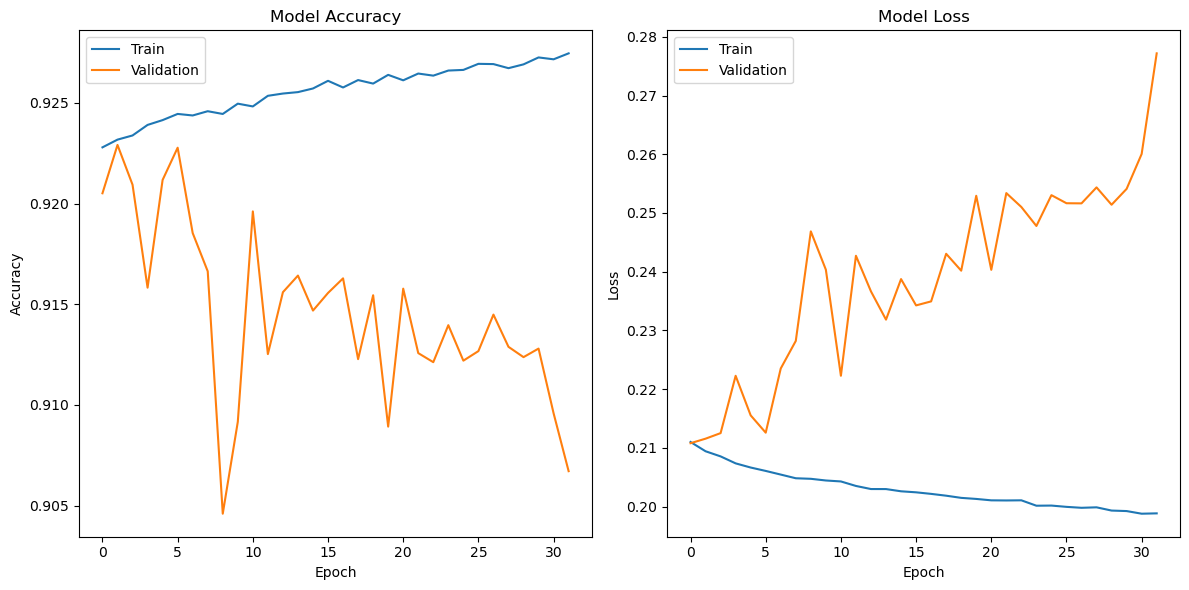

D:\Projects\110_JetscapeMl\hm.jetscapeml.data\simulation_results\jetml_classification_size_1000000_classifier_ElossNet_fold_2_training_history.json
D:\Projects\110_JetscapeMl\hm.jetscapeml.data\simulation_results\jetml_classification_size_1000000_classifier_ElossNet_fold_2_training_history.csv
D:\Projects\110_JetscapeMl\hm.jetscapeml.data\simulation_results\jetml_classification_size_1000000_classifier_ElossNet_fold_2_training_history.npy
6250/6250 [==============================] - 6s 1ms/step
y_pred [[2.3889018e-03 9.9761111e-01]
 [9.3759066e-01 6.2409230e-02]
 [1.0000000e+00 3.4364000e-08]
 ...
 [8.6608081e-04 9.9913394e-01]
 [6.6644065e-02 9.3335593e-01]
 [9.9971199e-01 2.8798170e-04]]
Accuracy: 0.896245
Confusion Matrix: [[84849 15180]
 [ 5571 94400]]
Epoch 1/32
22498/22500 [============================>.] - ETA: 0s - loss: 0.2059 - accuracy: 0.9256
Epoch 1: val_accuracy improved from -inf to 0.92848, saving model to D:\Projects\110_JetscapeMl\hm.jetscapeml.data\simulation_results\

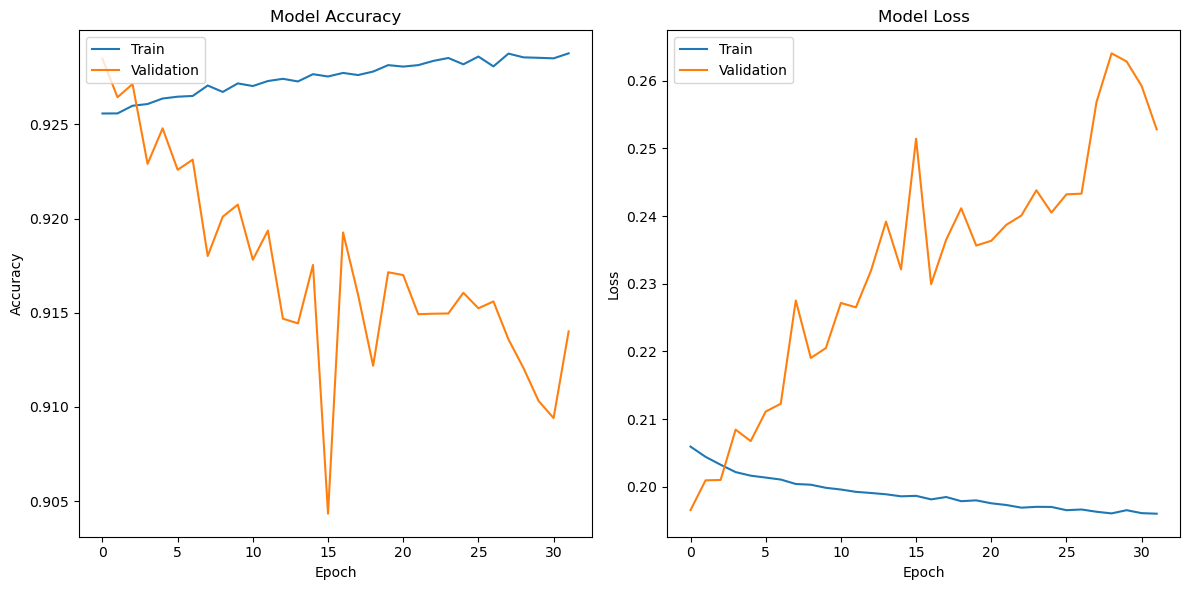

D:\Projects\110_JetscapeMl\hm.jetscapeml.data\simulation_results\jetml_classification_size_1000000_classifier_ElossNet_fold_3_training_history.json
D:\Projects\110_JetscapeMl\hm.jetscapeml.data\simulation_results\jetml_classification_size_1000000_classifier_ElossNet_fold_3_training_history.csv
D:\Projects\110_JetscapeMl\hm.jetscapeml.data\simulation_results\jetml_classification_size_1000000_classifier_ElossNet_fold_3_training_history.npy
6250/6250 [==============================] - 6s 944us/step
y_pred [[2.3569302e-03 9.9764454e-01]
 [9.5946759e-01 4.0527403e-02]
 [9.9999994e-01 6.6621745e-08]
 ...
 [1.8757312e-03 9.9812543e-01]
 [8.5347220e-02 9.1468173e-01]
 [9.9987078e-01 1.2910004e-04]]
Accuracy: 0.900475
Confusion Matrix: [[87788 12241]
 [ 7664 92307]]
Epoch 1/32
22490/22500 [============================>.] - ETA: 0s - loss: 0.2030 - accuracy: 0.9267
Epoch 1: val_accuracy improved from -inf to 0.93065, saving model to D:\Projects\110_JetscapeMl\hm.jetscapeml.data\simulation_result

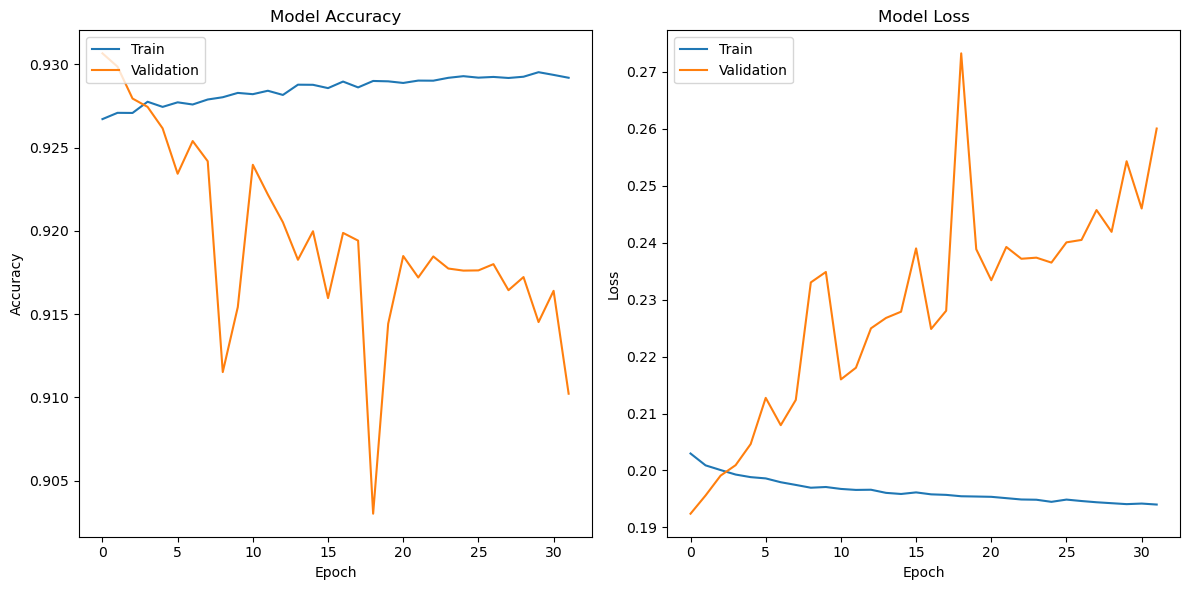

D:\Projects\110_JetscapeMl\hm.jetscapeml.data\simulation_results\jetml_classification_size_1000000_classifier_ElossNet_fold_4_training_history.json
D:\Projects\110_JetscapeMl\hm.jetscapeml.data\simulation_results\jetml_classification_size_1000000_classifier_ElossNet_fold_4_training_history.csv
D:\Projects\110_JetscapeMl\hm.jetscapeml.data\simulation_results\jetml_classification_size_1000000_classifier_ElossNet_fold_4_training_history.npy
6250/6250 [==============================] - 6s 900us/step
y_pred [[1.88568104e-02 9.81243610e-01]
 [9.66835797e-01 3.37628946e-02]
 [1.00000000e+00 1.90862863e-08]
 ...
 [4.85368073e-03 9.95158374e-01]
 [2.16578960e-01 7.75535762e-01]
 [9.99875128e-01 1.19486074e-04]]
Accuracy: 0.894175
Confusion Matrix: [[91105  8924]
 [12241 87730]]
Epoch 1/32
22499/22500 [============================>.] - ETA: 0s - loss: 0.2011 - accuracy: 0.9271
Epoch 1: val_accuracy improved from -inf to 0.93427, saving model to D:\Projects\110_JetscapeMl\hm.jetscapeml.data\simul

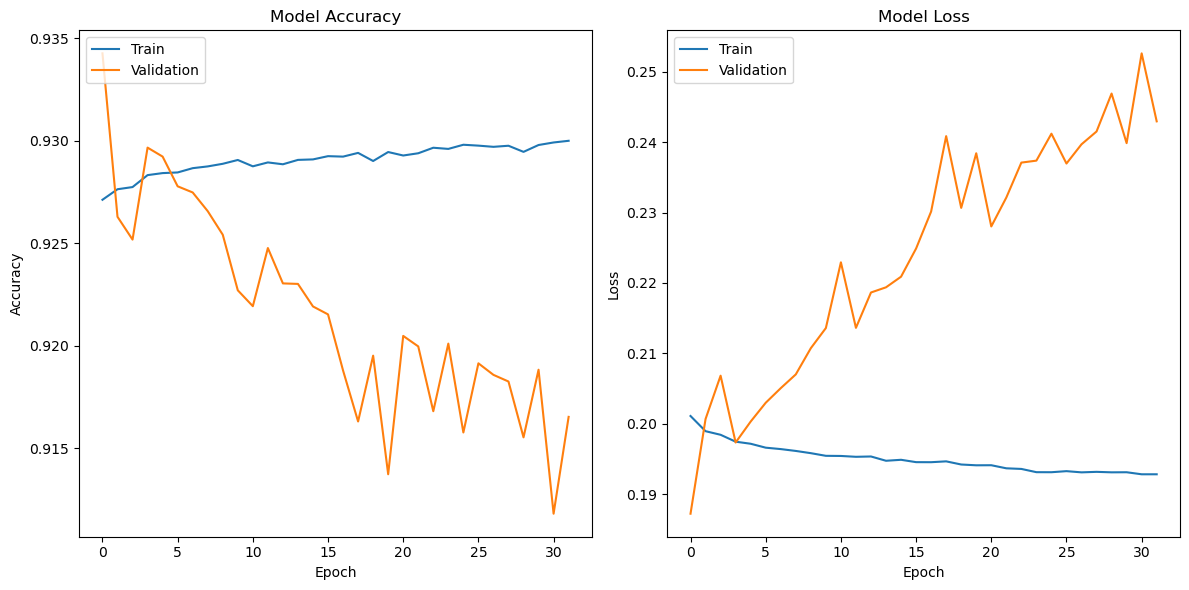

D:\Projects\110_JetscapeMl\hm.jetscapeml.data\simulation_results\jetml_classification_size_1000000_classifier_ElossNet_fold_5_training_history.json
D:\Projects\110_JetscapeMl\hm.jetscapeml.data\simulation_results\jetml_classification_size_1000000_classifier_ElossNet_fold_5_training_history.csv
D:\Projects\110_JetscapeMl\hm.jetscapeml.data\simulation_results\jetml_classification_size_1000000_classifier_ElossNet_fold_5_training_history.npy
6250/6250 [==============================] - 6s 919us/step
y_pred [[8.2566720e-03 9.9176055e-01]
 [9.5331687e-01 4.6700925e-02]
 [9.9999982e-01 1.9380552e-07]
 ...
 [2.7108677e-03 9.9728352e-01]
 [3.3109078e-01 6.6899639e-01]
 [9.9990684e-01 9.3741706e-05]]
Accuracy: 0.89795
Confusion Matrix: [[89516 10513]
 [ 9897 90074]]
Epoch 1/32
22494/22500 [============================>.] - ETA: 0s - loss: 0.1997 - accuracy: 0.9281
Epoch 1: val_accuracy improved from -inf to 0.93096, saving model to D:\Projects\110_JetscapeMl\hm.jetscapeml.data\simulation_results

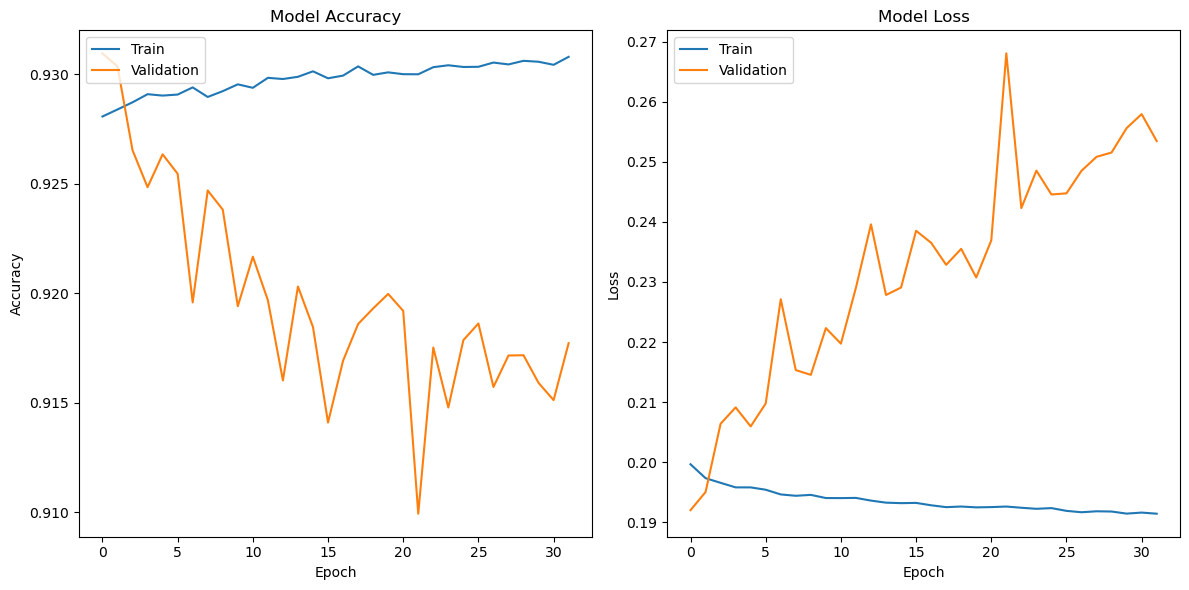

D:\Projects\110_JetscapeMl\hm.jetscapeml.data\simulation_results\jetml_classification_size_1000000_classifier_ElossNet_fold_6_training_history.json
D:\Projects\110_JetscapeMl\hm.jetscapeml.data\simulation_results\jetml_classification_size_1000000_classifier_ElossNet_fold_6_training_history.csv
D:\Projects\110_JetscapeMl\hm.jetscapeml.data\simulation_results\jetml_classification_size_1000000_classifier_ElossNet_fold_6_training_history.npy
6250/6250 [==============================] - 6s 895us/step
y_pred [[8.5180979e-03 9.9143356e-01]
 [9.0676212e-01 9.1944918e-02]
 [1.0000000e+00 3.5100097e-08]
 ...
 [2.0792633e-03 9.9791241e-01]
 [3.8044712e-01 6.1852622e-01]
 [9.9987829e-01 1.2220770e-04]]
Accuracy: 0.89903
Confusion Matrix: [[88602 11427]
 [ 8767 91204]]
Epoch 1/32
22498/22500 [============================>.] - ETA: 0s - loss: 0.1997 - accuracy: 0.9284
Epoch 1: val_accuracy improved from -inf to 0.93285, saving model to D:\Projects\110_JetscapeMl\hm.jetscapeml.data\simulation_results

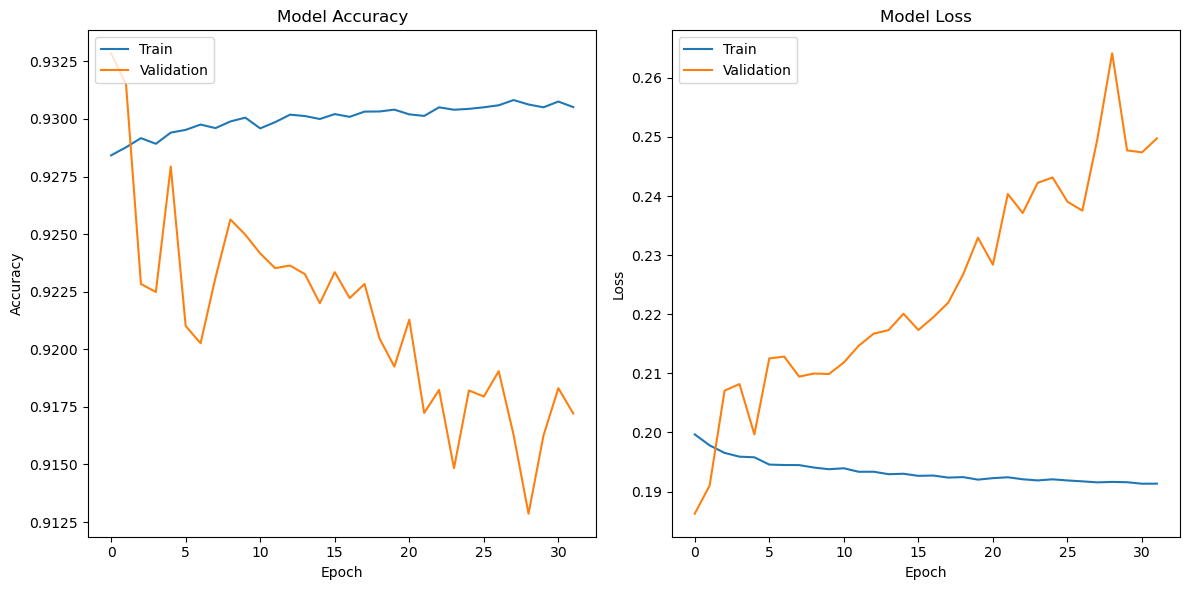

D:\Projects\110_JetscapeMl\hm.jetscapeml.data\simulation_results\jetml_classification_size_1000000_classifier_ElossNet_fold_7_training_history.json
D:\Projects\110_JetscapeMl\hm.jetscapeml.data\simulation_results\jetml_classification_size_1000000_classifier_ElossNet_fold_7_training_history.csv
D:\Projects\110_JetscapeMl\hm.jetscapeml.data\simulation_results\jetml_classification_size_1000000_classifier_ElossNet_fold_7_training_history.npy
6250/6250 [==============================] - 6s 895us/step
y_pred [[1.6359024e-02 9.8615938e-01]
 [9.2602837e-01 8.1505395e-02]
 [9.9999994e-01 8.0353807e-08]
 ...
 [4.8059812e-03 9.9600673e-01]
 [1.6005822e-01 8.5069877e-01]
 [9.9976367e-01 2.5022612e-04]]
Accuracy: 0.897675
Confusion Matrix: [[87293 12736]
 [ 7729 92242]]
Epoch 1/32
22486/22500 [============================>.] - ETA: 0s - loss: 0.1993 - accuracy: 0.9290
Epoch 1: val_accuracy improved from -inf to 0.93147, saving model to D:\Projects\110_JetscapeMl\hm.jetscapeml.data\simulation_result

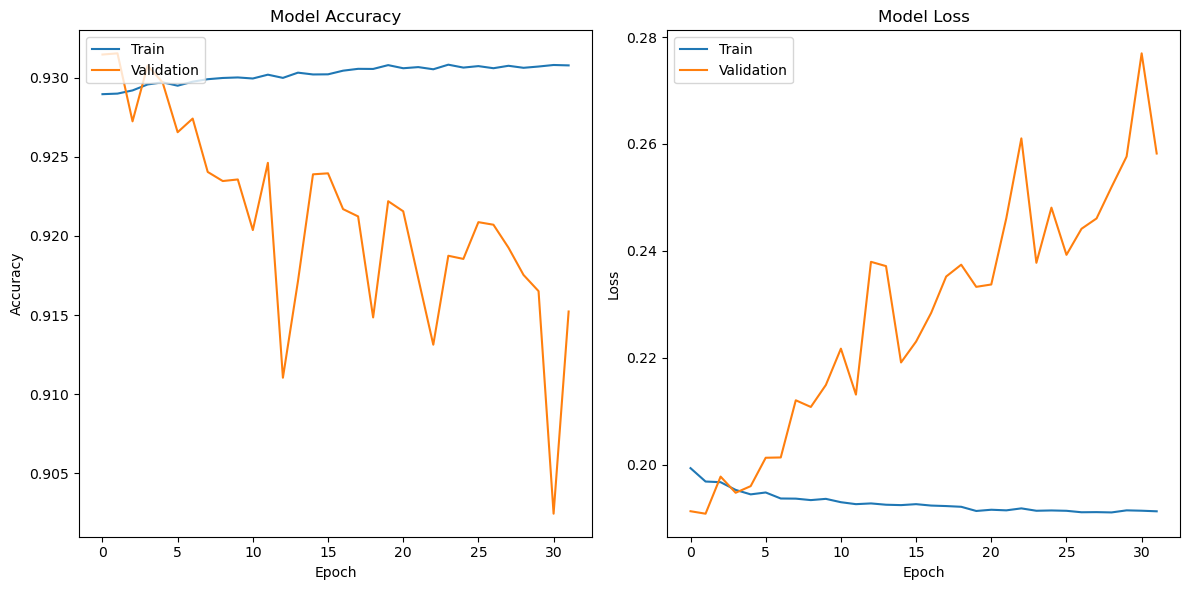

D:\Projects\110_JetscapeMl\hm.jetscapeml.data\simulation_results\jetml_classification_size_1000000_classifier_ElossNet_fold_8_training_history.json
D:\Projects\110_JetscapeMl\hm.jetscapeml.data\simulation_results\jetml_classification_size_1000000_classifier_ElossNet_fold_8_training_history.csv
D:\Projects\110_JetscapeMl\hm.jetscapeml.data\simulation_results\jetml_classification_size_1000000_classifier_ElossNet_fold_8_training_history.npy
6250/6250 [==============================] - 6s 876us/step
y_pred [[1.7846348e-02 9.8210055e-01]
 [9.1513354e-01 8.8987499e-02]
 [1.0000000e+00 9.0163255e-09]
 ...
 [6.8768798e-03 9.9321288e-01]
 [6.7637610e-01 3.2272616e-01]
 [9.9985385e-01 1.5365994e-04]]
Accuracy: 0.894255
Confusion Matrix: [[90465  9564]
 [11585 88386]]
Epoch 1/32
22468/22500 [============================>.] - ETA: 0s - loss: 0.1992 - accuracy: 0.9286
Epoch 1: val_accuracy improved from -inf to 0.92921, saving model to D:\Projects\110_JetscapeMl\hm.jetscapeml.data\simulation_result

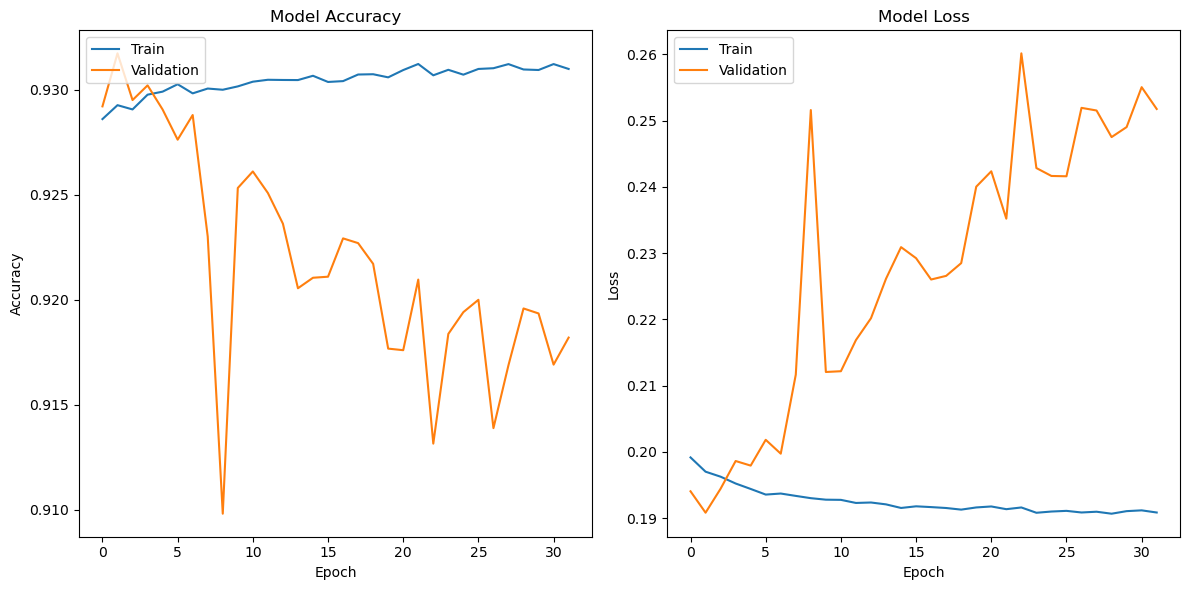

D:\Projects\110_JetscapeMl\hm.jetscapeml.data\simulation_results\jetml_classification_size_1000000_classifier_ElossNet_fold_9_training_history.json
D:\Projects\110_JetscapeMl\hm.jetscapeml.data\simulation_results\jetml_classification_size_1000000_classifier_ElossNet_fold_9_training_history.csv
D:\Projects\110_JetscapeMl\hm.jetscapeml.data\simulation_results\jetml_classification_size_1000000_classifier_ElossNet_fold_9_training_history.npy
6250/6250 [==============================] - 6s 936us/step
y_pred [[6.4962232e-03 9.9347597e-01]
 [9.6753675e-01 3.2434281e-02]
 [9.9999994e-01 3.9079840e-08]
 ...
 [1.6446610e-03 9.9834484e-01]
 [7.7517249e-02 9.2201173e-01]
 [9.9976015e-01 2.4075004e-04]]
Accuracy: 0.89789
Confusion Matrix: [[87401 12628]
 [ 7794 92177]]
Average Train Time: 33.589392137130105 minutes
Average Train Time: 33.589392137130105 minutes
Average Train Time: 33.589392137130105 minutes
Average Train Time: 33.589392137130105 minutes
Average Train Time: 33.589392137130105 minute

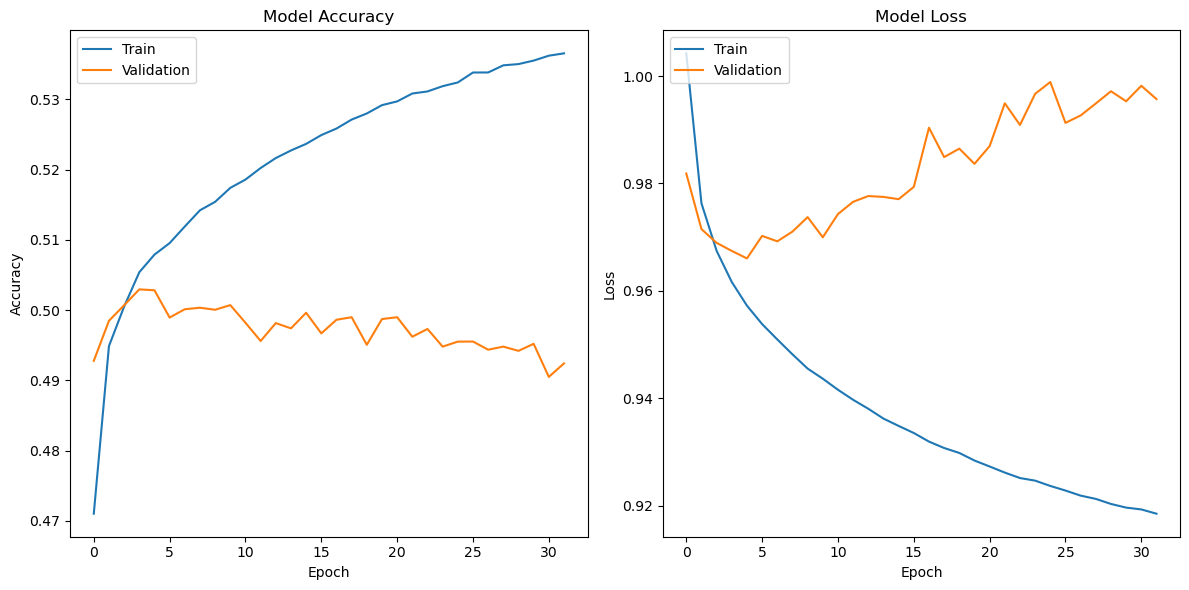

D:\Projects\110_JetscapeMl\hm.jetscapeml.data\simulation_results\jetml_classification_size_1000000_classifier_AlphaSNet_fold_0_training_history.json
D:\Projects\110_JetscapeMl\hm.jetscapeml.data\simulation_results\jetml_classification_size_1000000_classifier_AlphaSNet_fold_0_training_history.csv
D:\Projects\110_JetscapeMl\hm.jetscapeml.data\simulation_results\jetml_classification_size_1000000_classifier_AlphaSNet_fold_0_training_history.npy
6250/6250 [==============================] - 6s 963us/step
y_pred [[0.27179983 0.37800145 0.35019872]
 [0.59634036 0.32527208 0.07838754]
 [0.01150671 0.05710094 0.9313924 ]
 ...
 [0.30657464 0.31036422 0.38306117]
 [0.35239097 0.32772568 0.31988335]
 [0.46066913 0.40480986 0.13452101]]
Accuracy: 0.490985
Confusion Matrix: [[46499 14019  6083]
 [31413 20937 14273]
 [19196 16819 30761]]
Epoch 1/32
22460/22500 [============================>.] - ETA: 0s - loss: 0.9275 - accuracy: 0.5316
Epoch 1: val_accuracy improved from -inf to 0.53664, saving model 

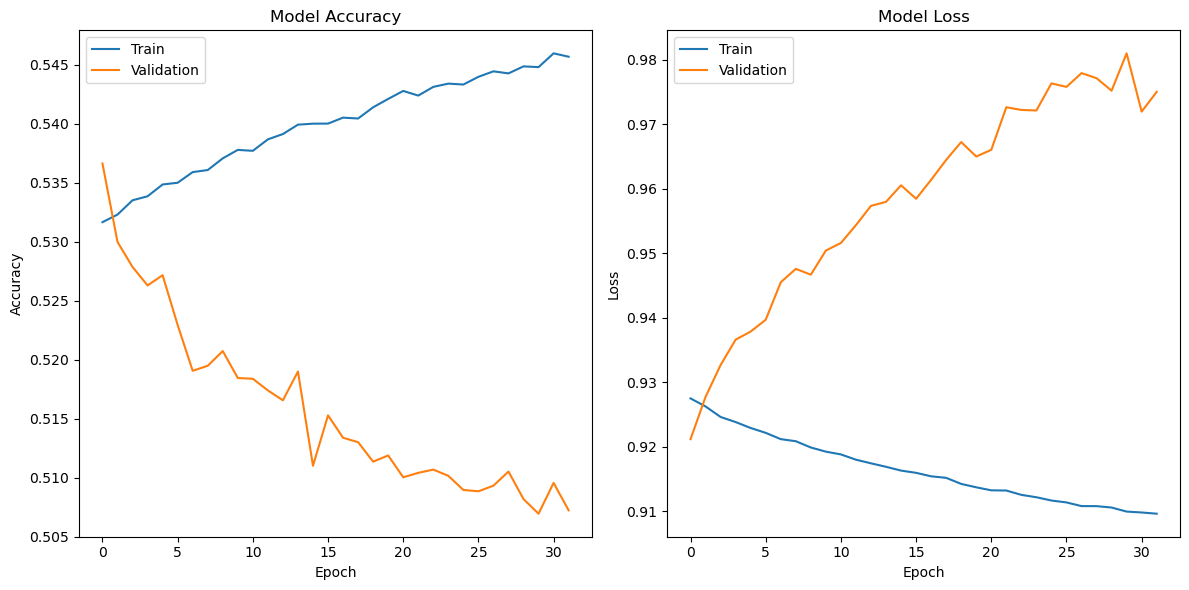

D:\Projects\110_JetscapeMl\hm.jetscapeml.data\simulation_results\jetml_classification_size_1000000_classifier_AlphaSNet_fold_1_training_history.json
D:\Projects\110_JetscapeMl\hm.jetscapeml.data\simulation_results\jetml_classification_size_1000000_classifier_AlphaSNet_fold_1_training_history.csv
D:\Projects\110_JetscapeMl\hm.jetscapeml.data\simulation_results\jetml_classification_size_1000000_classifier_AlphaSNet_fold_1_training_history.npy
6250/6250 [==============================] - 6s 925us/step
y_pred [[0.34723717 0.36783108 0.28493175]
 [0.5693771  0.31549668 0.11512624]
 [0.00663134 0.10536272 0.888006  ]
 ...
 [0.25964862 0.31184205 0.42850932]
 [0.37609157 0.31367642 0.31023195]
 [0.5091288  0.37313688 0.11773437]]
Accuracy: 0.490815
Confusion Matrix: [[50150  8096  8355]
 [35078 13973 17572]
 [22209 10527 34040]]
Epoch 1/32
22480/22500 [============================>.] - ETA: 0s - loss: 0.9175 - accuracy: 0.5412
Epoch 1: val_accuracy improved from -inf to 0.54230, saving model 

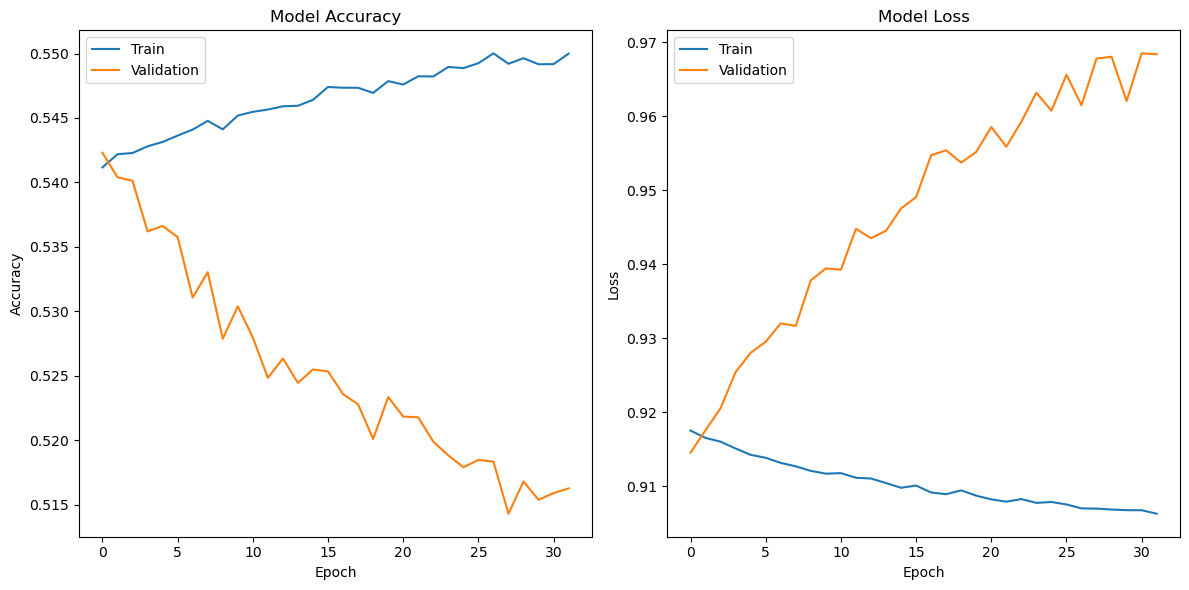

D:\Projects\110_JetscapeMl\hm.jetscapeml.data\simulation_results\jetml_classification_size_1000000_classifier_AlphaSNet_fold_2_training_history.json
D:\Projects\110_JetscapeMl\hm.jetscapeml.data\simulation_results\jetml_classification_size_1000000_classifier_AlphaSNet_fold_2_training_history.csv
D:\Projects\110_JetscapeMl\hm.jetscapeml.data\simulation_results\jetml_classification_size_1000000_classifier_AlphaSNet_fold_2_training_history.npy
6250/6250 [==============================] - 6s 988us/step
y_pred [[0.2898768  0.38815197 0.3219712 ]
 [0.61529946 0.3059423  0.07875827]
 [0.00648306 0.13496077 0.85855615]
 ...
 [0.2352875  0.2932685  0.47144395]
 [0.26409936 0.32650962 0.409391  ]
 [0.45815158 0.4162277  0.12562068]]
Accuracy: 0.48721
Confusion Matrix: [[44438  9373 12790]
 [29713 14186 22724]
 [18052  9906 38818]]
Epoch 1/32
22479/22500 [============================>.] - ETA: 0s - loss: 0.9141 - accuracy: 0.5455
Epoch 1: val_accuracy improved from -inf to 0.54896, saving model t

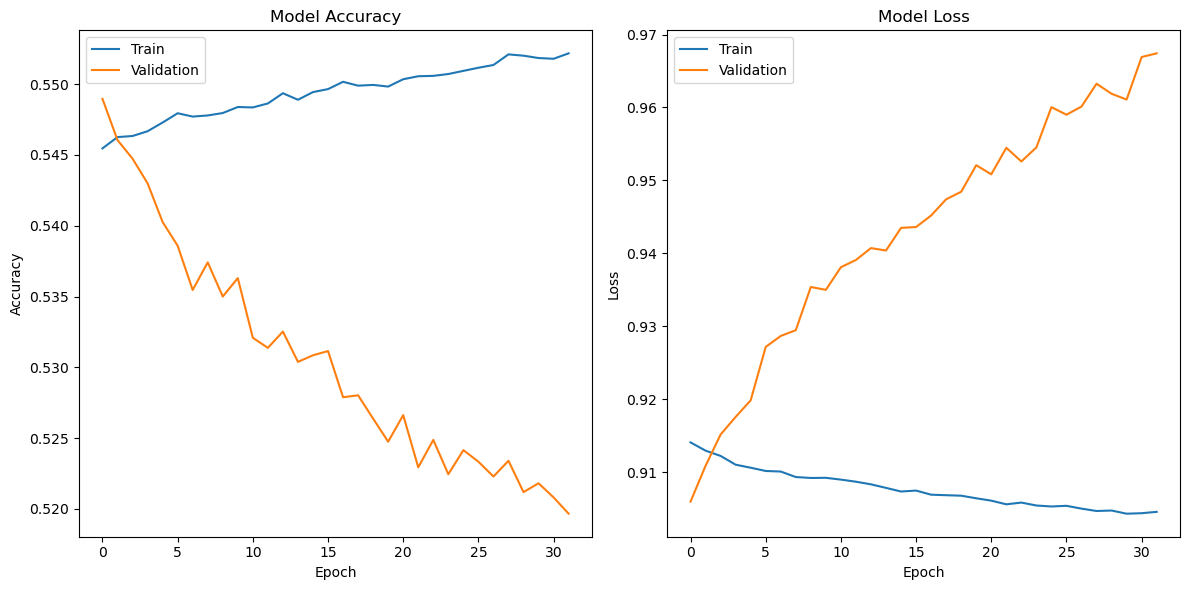

D:\Projects\110_JetscapeMl\hm.jetscapeml.data\simulation_results\jetml_classification_size_1000000_classifier_AlphaSNet_fold_3_training_history.json
D:\Projects\110_JetscapeMl\hm.jetscapeml.data\simulation_results\jetml_classification_size_1000000_classifier_AlphaSNet_fold_3_training_history.csv
D:\Projects\110_JetscapeMl\hm.jetscapeml.data\simulation_results\jetml_classification_size_1000000_classifier_AlphaSNet_fold_3_training_history.npy
6250/6250 [==============================] - 6s 946us/step
y_pred [[0.29839677 0.41902637 0.2825769 ]
 [0.6039458  0.31343988 0.08261427]
 [0.00440256 0.10627591 0.8893215 ]
 ...
 [0.3292549  0.28501323 0.38573188]
 [0.33532807 0.32740834 0.33726355]
 [0.465155   0.41898742 0.11585754]]
Accuracy: 0.48655
Confusion Matrix: [[47148 12360  7093]
 [32316 18896 15411]
 [20256 15254 31266]]
Epoch 1/32
22461/22500 [============================>.] - ETA: 0s - loss: 0.9118 - accuracy: 0.5476
Epoch 1: val_accuracy improved from -inf to 0.55459, saving model t

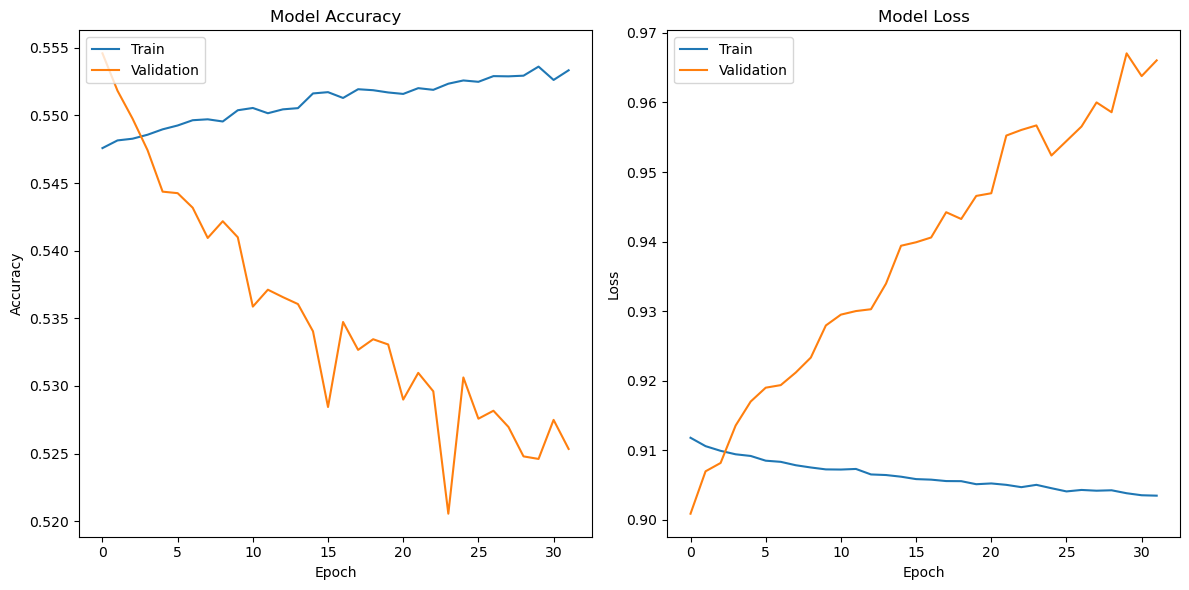

D:\Projects\110_JetscapeMl\hm.jetscapeml.data\simulation_results\jetml_classification_size_1000000_classifier_AlphaSNet_fold_4_training_history.json
D:\Projects\110_JetscapeMl\hm.jetscapeml.data\simulation_results\jetml_classification_size_1000000_classifier_AlphaSNet_fold_4_training_history.csv
D:\Projects\110_JetscapeMl\hm.jetscapeml.data\simulation_results\jetml_classification_size_1000000_classifier_AlphaSNet_fold_4_training_history.npy
6250/6250 [==============================] - 10s 2ms/step
y_pred [[0.33586127 0.4188758  0.24526298]
 [0.6251783  0.309416   0.06540571]
 [0.01167005 0.12633394 0.8619961 ]
 ...
 [0.3223574  0.32907975 0.34856287]
 [0.34687704 0.36720914 0.28591385]
 [0.4509814  0.4249794  0.12403917]]
Accuracy: 0.484805
Confusion Matrix: [[44596 13471  8534]
 [30197 18737 17689]
 [18650 14498 33628]]
Epoch 1/32
22481/22500 [============================>.] - ETA: 0s - loss: 0.9109 - accuracy: 0.5497
Epoch 1: val_accuracy improved from -inf to 0.55205, saving model t

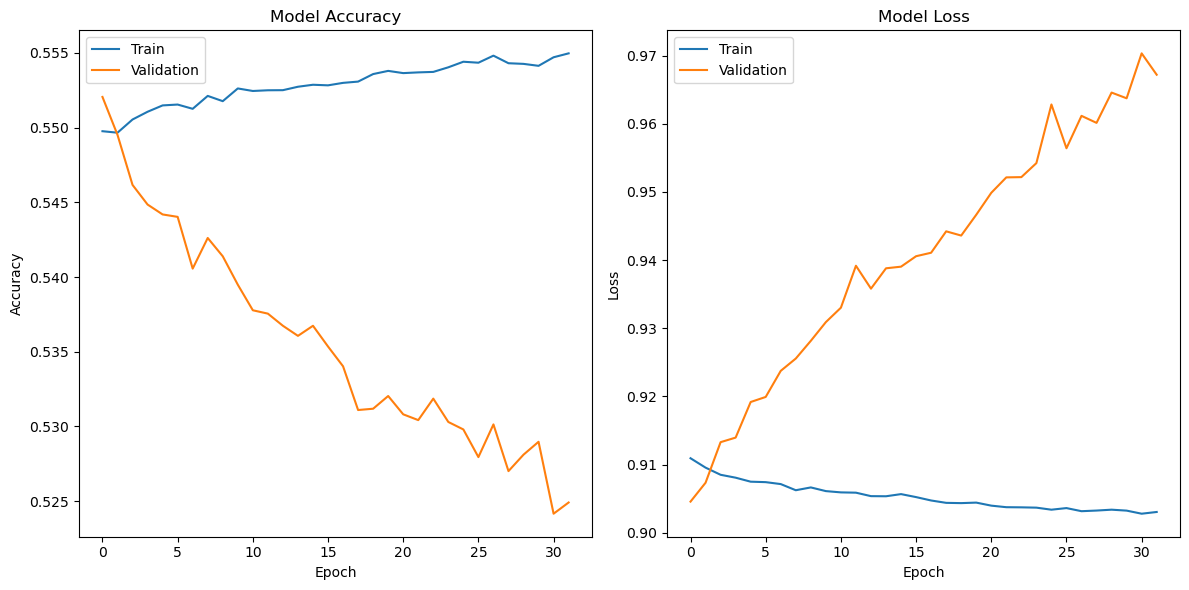

D:\Projects\110_JetscapeMl\hm.jetscapeml.data\simulation_results\jetml_classification_size_1000000_classifier_AlphaSNet_fold_5_training_history.json
D:\Projects\110_JetscapeMl\hm.jetscapeml.data\simulation_results\jetml_classification_size_1000000_classifier_AlphaSNet_fold_5_training_history.csv
D:\Projects\110_JetscapeMl\hm.jetscapeml.data\simulation_results\jetml_classification_size_1000000_classifier_AlphaSNet_fold_5_training_history.npy
6250/6250 [==============================] - 6s 959us/step
y_pred [[0.35902894 0.42118078 0.21979028]
 [0.62416816 0.30661124 0.06922058]
 [0.0190792  0.1182543  0.8626665 ]
 ...
 [0.39128    0.29573843 0.31298164]
 [0.33031258 0.3310236  0.3386638 ]
 [0.37782353 0.47952724 0.1426492 ]]
Accuracy: 0.4825
Confusion Matrix: [[44001 13874  8726]
 [29816 20237 16570]
 [18407 16107 32262]]
Epoch 1/32
22465/22500 [============================>.] - ETA: 0s - loss: 0.9106 - accuracy: 0.5504
Epoch 1: val_accuracy improved from -inf to 0.56002, saving model to

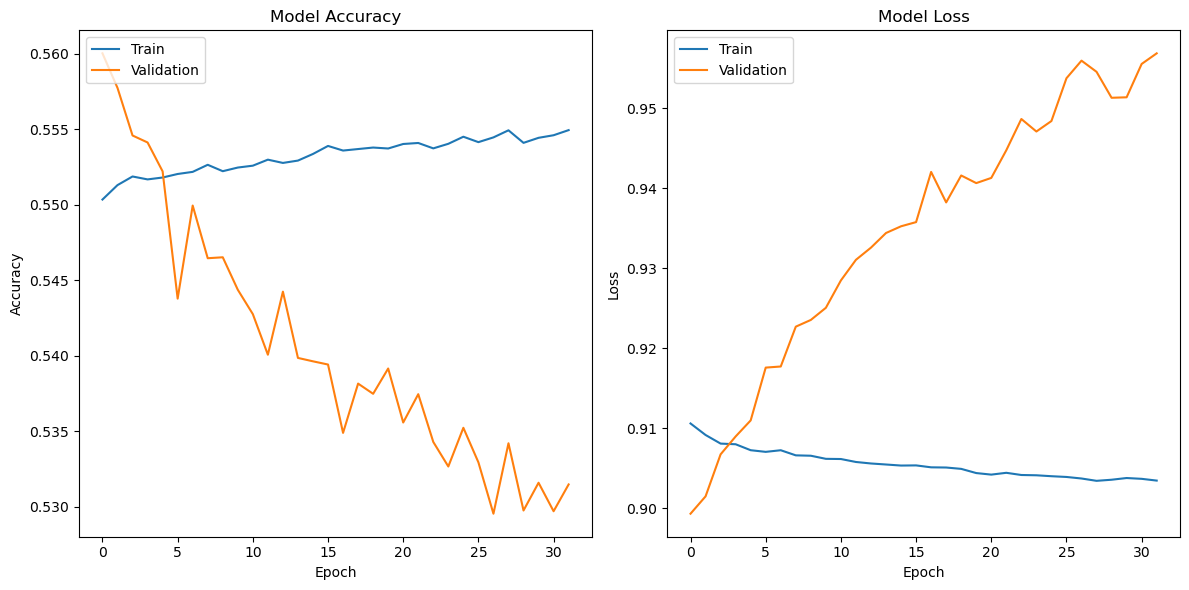

D:\Projects\110_JetscapeMl\hm.jetscapeml.data\simulation_results\jetml_classification_size_1000000_classifier_AlphaSNet_fold_6_training_history.json
D:\Projects\110_JetscapeMl\hm.jetscapeml.data\simulation_results\jetml_classification_size_1000000_classifier_AlphaSNet_fold_6_training_history.csv
D:\Projects\110_JetscapeMl\hm.jetscapeml.data\simulation_results\jetml_classification_size_1000000_classifier_AlphaSNet_fold_6_training_history.npy
6250/6250 [==============================] - 6s 958us/step
y_pred [[0.28891173 0.42103675 0.2900515 ]
 [0.62343264 0.305279   0.07128836]
 [0.02621796 0.13363901 0.840143  ]
 ...
 [0.32126427 0.31523064 0.3635051 ]
 [0.32619107 0.34183392 0.331975  ]
 [0.3772936  0.44615674 0.17654961]]
Accuracy: 0.481945
Confusion Matrix: [[43643 11629 11329]
 [29734 16957 19932]
 [18362 12625 35789]]
Epoch 1/32
22483/22500 [============================>.] - ETA: 0s - loss: 0.9101 - accuracy: 0.5514
Epoch 1: val_accuracy improved from -inf to 0.55695, saving model 

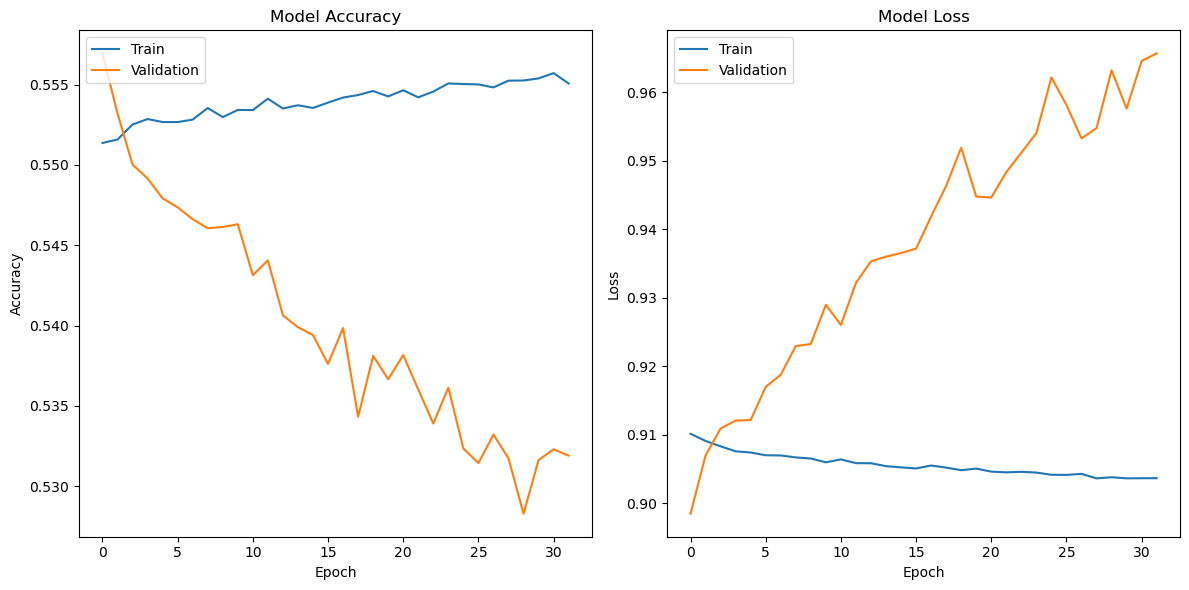

D:\Projects\110_JetscapeMl\hm.jetscapeml.data\simulation_results\jetml_classification_size_1000000_classifier_AlphaSNet_fold_7_training_history.json
D:\Projects\110_JetscapeMl\hm.jetscapeml.data\simulation_results\jetml_classification_size_1000000_classifier_AlphaSNet_fold_7_training_history.csv
D:\Projects\110_JetscapeMl\hm.jetscapeml.data\simulation_results\jetml_classification_size_1000000_classifier_AlphaSNet_fold_7_training_history.npy
6250/6250 [==============================] - 6s 931us/step
y_pred [[0.33791614 0.33319297 0.3288909 ]
 [0.6140212  0.31392857 0.07205028]
 [0.00360168 0.16957413 0.82682425]
 ...
 [0.32658142 0.32190254 0.35151604]
 [0.31385556 0.34843847 0.337706  ]
 [0.37452286 0.45229408 0.17318298]]
Accuracy: 0.485085
Confusion Matrix: [[46554 10115  9932]
 [31936 15660 19027]
 [20205 11768 34803]]
Epoch 1/32
22485/22500 [============================>.] - ETA: 0s - loss: 0.9107 - accuracy: 0.5518
Epoch 1: val_accuracy improved from -inf to 0.55026, saving model 

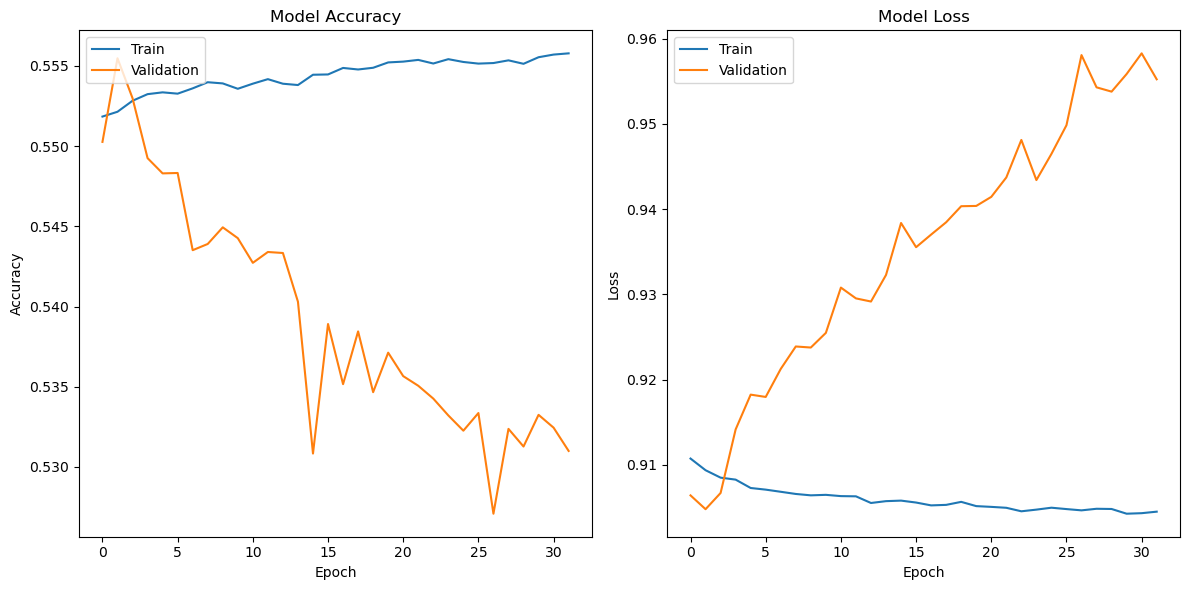

D:\Projects\110_JetscapeMl\hm.jetscapeml.data\simulation_results\jetml_classification_size_1000000_classifier_AlphaSNet_fold_8_training_history.json
D:\Projects\110_JetscapeMl\hm.jetscapeml.data\simulation_results\jetml_classification_size_1000000_classifier_AlphaSNet_fold_8_training_history.csv
D:\Projects\110_JetscapeMl\hm.jetscapeml.data\simulation_results\jetml_classification_size_1000000_classifier_AlphaSNet_fold_8_training_history.npy
6250/6250 [==============================] - 6s 924us/step
y_pred [[0.37518978 0.35917082 0.26563936]
 [0.6103306  0.31613007 0.0735394 ]
 [0.00280397 0.11926644 0.87792957]
 ...
 [0.4017228  0.31789246 0.28038478]
 [0.30476102 0.35017842 0.34506056]
 [0.38670245 0.45767784 0.15561973]]
Accuracy: 0.48478
Confusion Matrix: [[45280 12553  8768]
 [30853 18705 17065]
 [19412 14393 32971]]
Epoch 1/32
22457/22500 [============================>.] - ETA: 0s - loss: 0.9111 - accuracy: 0.5521
Epoch 1: val_accuracy improved from -inf to 0.55949, saving model t

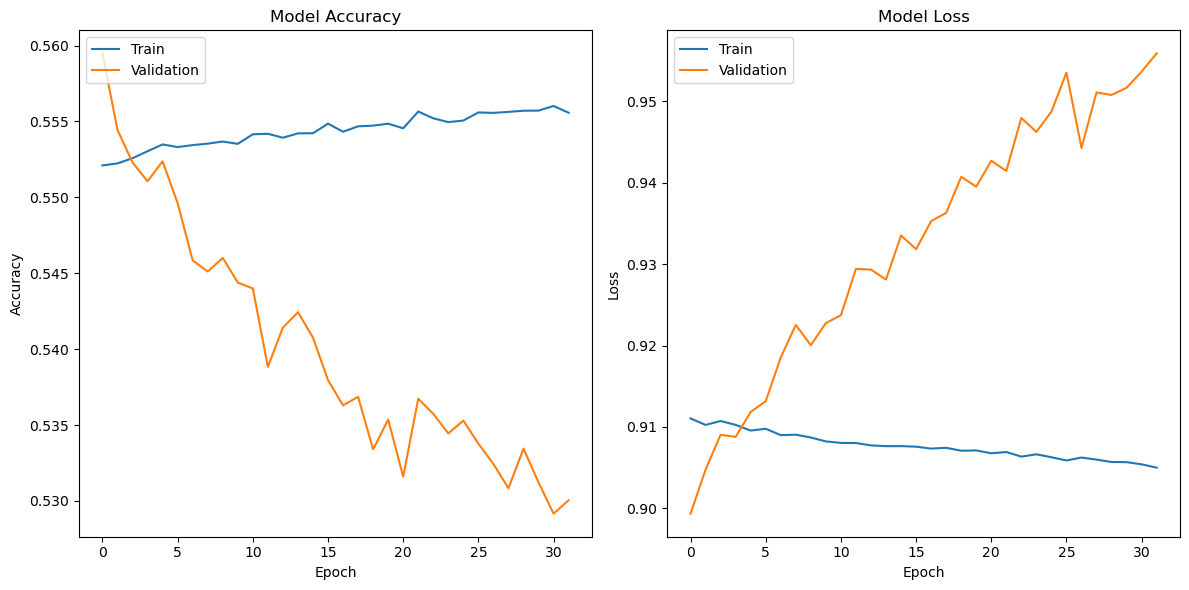

D:\Projects\110_JetscapeMl\hm.jetscapeml.data\simulation_results\jetml_classification_size_1000000_classifier_AlphaSNet_fold_9_training_history.json
D:\Projects\110_JetscapeMl\hm.jetscapeml.data\simulation_results\jetml_classification_size_1000000_classifier_AlphaSNet_fold_9_training_history.csv
D:\Projects\110_JetscapeMl\hm.jetscapeml.data\simulation_results\jetml_classification_size_1000000_classifier_AlphaSNet_fold_9_training_history.npy
6250/6250 [==============================] - 6s 991us/step
y_pred [[0.35549703 0.3338858  0.31061718]
 [0.61270475 0.31167105 0.07562418]
 [0.01063846 0.1778264  0.8115351 ]
 ...
 [0.3335168  0.3045696  0.36191353]
 [0.14998606 0.36512107 0.48489287]
 [0.3033897  0.48696336 0.20964701]]
Accuracy: 0.482805
Confusion Matrix: [[42833 11499 12269]
 [28595 17878 20150]
 [17664 13262 35850]]
Average Train Time: 19.005228311618172 minutes
Average Train Time: 19.005228311618172 minutes
Average Train Time: 19.005228311618172 minutes
Average Train Time: 19.00

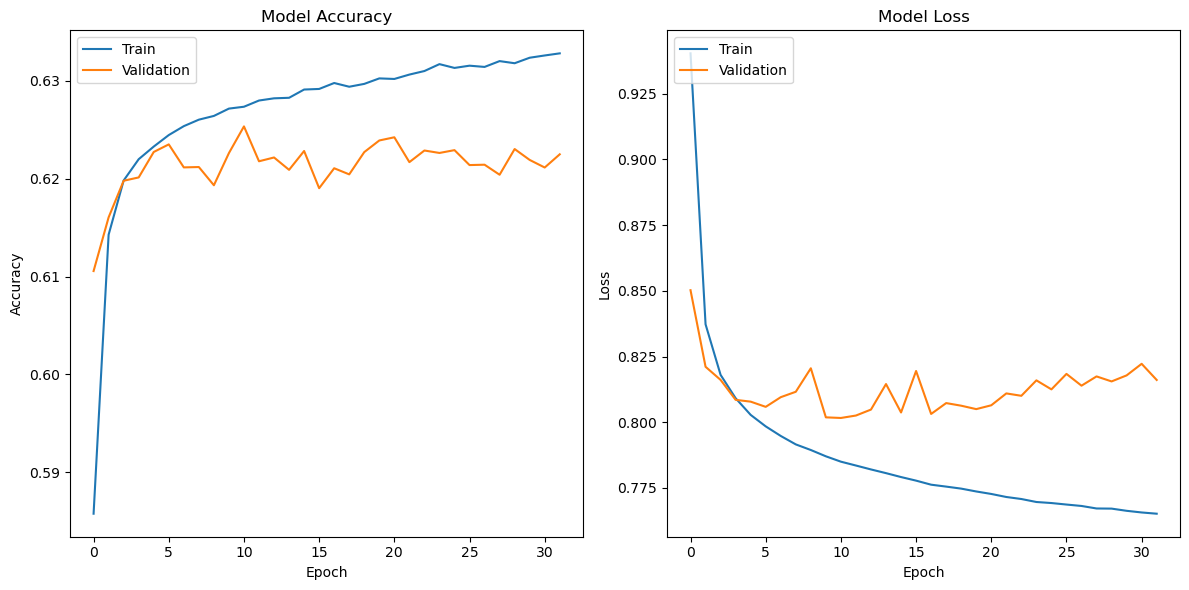

D:\Projects\110_JetscapeMl\hm.jetscapeml.data\simulation_results\jetml_classification_size_1000000_classifier_Q0Net_fold_0_training_history.json
D:\Projects\110_JetscapeMl\hm.jetscapeml.data\simulation_results\jetml_classification_size_1000000_classifier_Q0Net_fold_0_training_history.csv
D:\Projects\110_JetscapeMl\hm.jetscapeml.data\simulation_results\jetml_classification_size_1000000_classifier_Q0Net_fold_0_training_history.npy
6250/6250 [==============================] - 6s 912us/step
y_pred [[9.7453576e-01 2.0671433e-02 2.6930138e-03 2.0997208e-03]
 [1.9822804e-02 2.8942969e-01 3.7634236e-01 3.1440508e-01]
 [5.7136285e-06 2.6502389e-01 3.4906915e-01 3.8590121e-01]
 ...
 [9.9402231e-01 5.7229018e-03 1.5728534e-04 9.7533164e-05]
 [8.3463180e-01 6.6309214e-02 5.5994302e-02 4.3064687e-02]
 [1.2374384e-03 2.8502849e-01 3.7015775e-01 3.4357634e-01]]
Accuracy: 0.622485
Confusion Matrix: [[96252  1164  2481    74]
 [ 7453  2551 17955  5197]
 [ 5507  2656 19523  5753]
 [ 5278  2727 19258  61

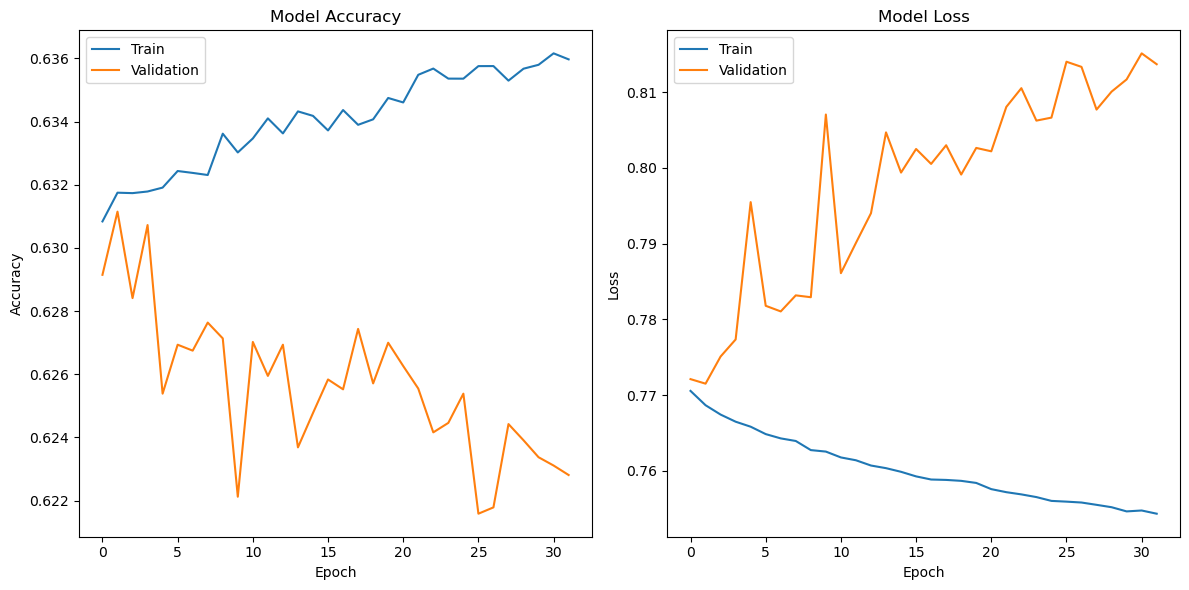

D:\Projects\110_JetscapeMl\hm.jetscapeml.data\simulation_results\jetml_classification_size_1000000_classifier_Q0Net_fold_1_training_history.json
D:\Projects\110_JetscapeMl\hm.jetscapeml.data\simulation_results\jetml_classification_size_1000000_classifier_Q0Net_fold_1_training_history.csv
D:\Projects\110_JetscapeMl\hm.jetscapeml.data\simulation_results\jetml_classification_size_1000000_classifier_Q0Net_fold_1_training_history.npy
6250/6250 [==============================] - 6s 950us/step
y_pred [[9.72406685e-01 2.26306953e-02 2.54749530e-03 2.41519418e-03]
 [6.02513626e-02 3.74325514e-01 3.02160054e-01 2.63263017e-01]
 [4.34268912e-07 2.88429499e-01 3.25019866e-01 3.86550128e-01]
 ...
 [9.93695438e-01 6.09277887e-03 1.07450425e-04 1.04329229e-04]
 [6.50937706e-02 3.97201538e-01 2.71780521e-01 2.65924215e-01]
 [3.41446546e-04 2.88966060e-01 3.52106422e-01 3.58586013e-01]]
Accuracy: 0.6182
Confusion Matrix: [[94676  3927  1210   158]
 [ 6331  9331  9227  8267]
 [ 4495  9782 10049  9113]
 

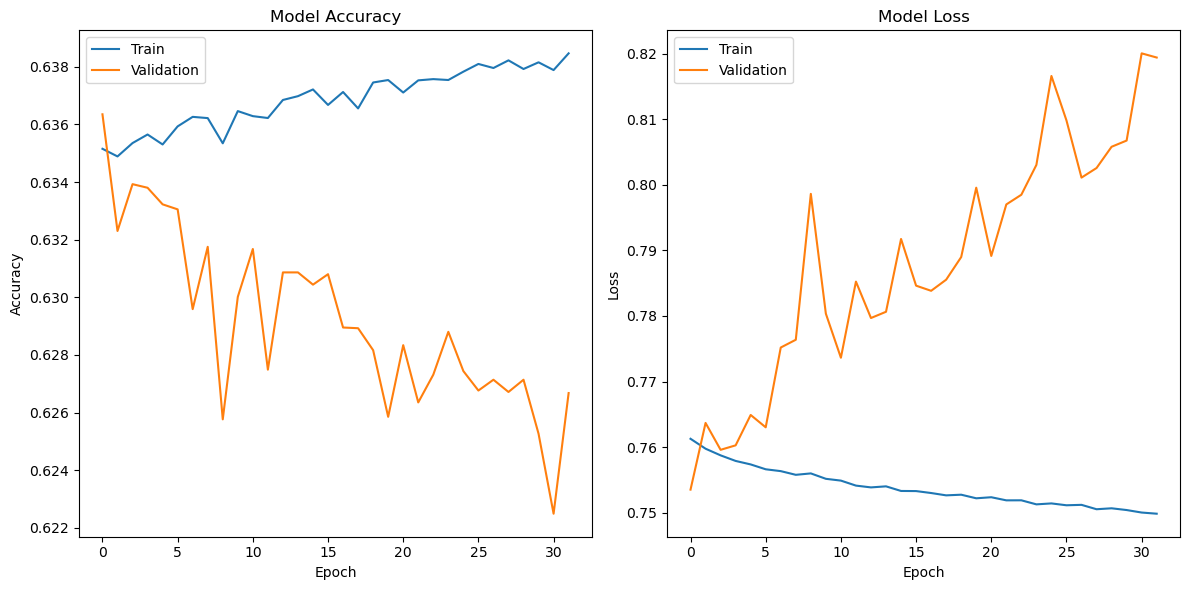

D:\Projects\110_JetscapeMl\hm.jetscapeml.data\simulation_results\jetml_classification_size_1000000_classifier_Q0Net_fold_2_training_history.json
D:\Projects\110_JetscapeMl\hm.jetscapeml.data\simulation_results\jetml_classification_size_1000000_classifier_Q0Net_fold_2_training_history.csv
D:\Projects\110_JetscapeMl\hm.jetscapeml.data\simulation_results\jetml_classification_size_1000000_classifier_Q0Net_fold_2_training_history.npy
6250/6250 [==============================] - 6s 934us/step
y_pred [[9.8914647e-01 5.9148679e-03 2.7431243e-03 2.1955397e-03]
 [4.9770970e-02 3.2814571e-01 3.7434164e-01 2.4774171e-01]
 [9.1642062e-07 2.5372988e-01 3.9868006e-01 3.4758919e-01]
 ...
 [9.9791807e-01 1.9620247e-03 6.6596040e-05 5.3299085e-05]
 [4.7627598e-01 2.3603736e-01 1.5840310e-01 1.2928356e-01]
 [1.5119311e-03 2.9272515e-01 3.6371836e-01 3.4204456e-01]]
Accuracy: 0.617935
Confusion Matrix: [[96449  2053  1349   120]
 [ 7941  6176 18519   520]
 [ 6127  6340 20332   640]
 [ 5911  6160 20733   6

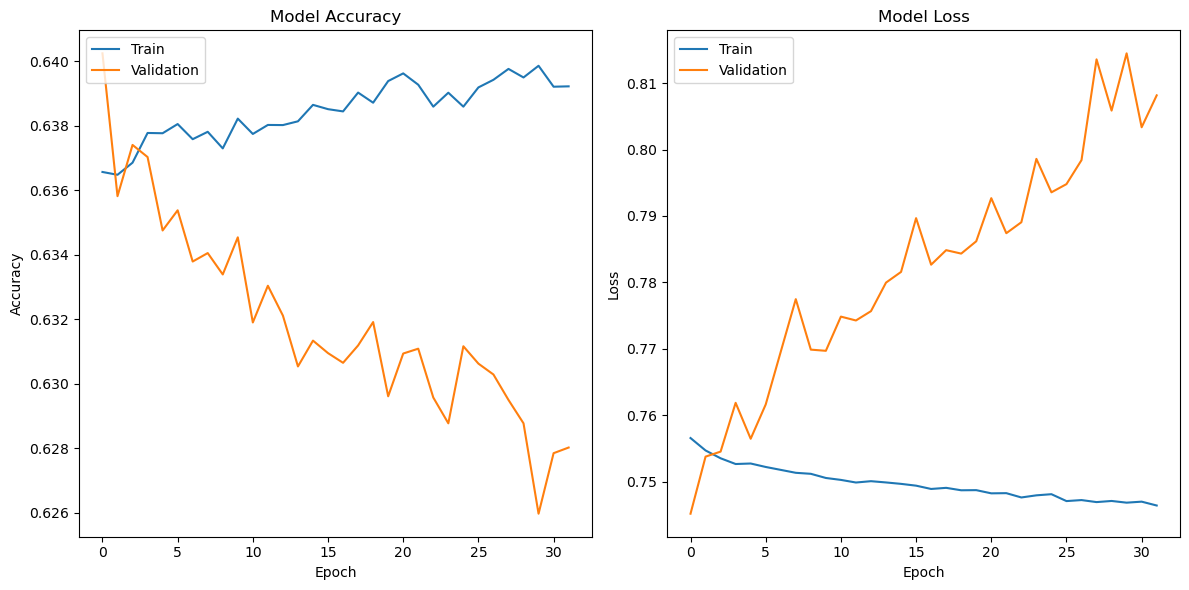

D:\Projects\110_JetscapeMl\hm.jetscapeml.data\simulation_results\jetml_classification_size_1000000_classifier_Q0Net_fold_3_training_history.json
D:\Projects\110_JetscapeMl\hm.jetscapeml.data\simulation_results\jetml_classification_size_1000000_classifier_Q0Net_fold_3_training_history.csv
D:\Projects\110_JetscapeMl\hm.jetscapeml.data\simulation_results\jetml_classification_size_1000000_classifier_Q0Net_fold_3_training_history.npy
6250/6250 [==============================] - 6s 930us/step
y_pred [[9.7541171e-01 2.0536263e-02 2.4153681e-03 1.6367231e-03]
 [1.1757677e-02 2.8223300e-01 3.8984048e-01 3.1616887e-01]
 [2.5182737e-07 2.4232343e-01 3.7020805e-01 3.8746825e-01]
 ...
 [9.8970324e-01 1.0136325e-02 9.5727548e-05 6.4715823e-05]
 [7.7172369e-01 1.1389406e-01 6.8823621e-02 4.5558650e-02]
 [1.7949370e-03 2.8699923e-01 3.7033063e-01 3.4087524e-01]]
Accuracy: 0.618765
Confusion Matrix: [[95425  1338  3043   165]
 [ 7046  1693 23119  1298]
 [ 5180  1775 24972  1512]
 [ 5057  1691 25023  16

MemoryError: Unable to allocate 2.75 GiB for an array with shape (720000, 32, 32) and data type float32

In [26]:
monitor = 'val_accuracy'  # 'val_accuracy' or 'val_loss'
n_epochs = 32
k_folds = 10  # You can adjust the number of folds

# defining dataset sizes and classifiers

# Sizes of datasets
# dataset_sizes = [1000]
# dataset_sizes = [100000]
dataset_sizes = [1000000]
# dataset_sizes = [1000, 10000]
# dataset_sizes = [1000, 10000,100000]
# dataset_sizes = [1000, 10000, 100000, 1000000]

print(simulation_directory_path)
# simulation_path=f'{simulation_directory_path}jetml_classification_{class_labels_str}'
simulation_path=f'{simulation_directory_path}jetml_classification'
train_and_evaluate_classifier_for_all_datasets(dataset_sizes,classifiers,simulation_path,n_epochs, monitor, k_folds)

In [27]:
results_kfold_errorbar

NameError: name 'results_kfold_errorbar' is not defined